# Parallel LSTM Training for Sequence Prediction from Sequential Data

Vietnam National University - University of Science 

CSC14116 - Applied Parallel Programming

20120105 - Le Hoang Huy

20120120 - Nguyen Viet Khoa

<br>

**Resources:**

* Github Repository: [Github](https://github.com/nvkhoa14/LTSM-Parallel)

* Source Code: [LSTM.ipynb]()

* Detailed Report: [README]()

<br>

**Table of Contents:**

* Introduction
* Background
  - About RNN and LSTM
  - LSTM Architecture
* Initial Setups
  - Initialize hyper-parameters
  - Download dataset
  - Import libraries
  - Define functions
    + General Functions
    + One-hot Encoding Functions
    + Activation Functions
    + Neural Network Functions
    + Inference Functions
* Dataset
  - Information
  - Task to solve
  - Preprocessing
  - Sequential
* Result
  
* Conclusion



# Introduction

Trong dự án này, chúng ta sẽ phân tích và song song mô hình LSTM (RNN - Mạng thần kinh tái phát) để cải thiện tốc độ và hiệu quả đào tạo của nó. Bằng cách sử dụng xử lý song song và tính toán GPU, mô hình sẽ có thể xử lý các tập dữ liệu lớn hơn và có thời gian đào tạo ngắn hơn. Nhiệm vụ cụ thể mà chúng ta muốn áp dụng bằng mô hình LSTM trong dự án này là dự đoán chuỗi thời gian – dự đoán trình tự từ dữ liệu tuần tự. Chúng ta sẽ triển khai mô hình LSTM thô chỉ sử dụng thư viện Numpy, phân tích, song song hóa bằng thư viện Numba và đo lường hiệu quả của phiên bản song song so với phiên bản tuần tự.
Keywords: `Parallel Processing`, `GPU Computing`, `NVIDIA CUDA`, `Recurrent Neural Network (RNN)`, `Long Short-Term Memory (LSTM)`

# Background

## About RNN and LSTM

Mạng nơ-ron hồi quy (RNN) huấn luyện trên đầu vào chứa các chuỗi dữ liệu, trong đó nó học về mối quan hệ phụ thuộc vào thời gian giữa các phần khác nhau của đầu vào. Ví dụ, nếu chúng ta đưa vào một chuỗi các từ làm đầu vào, tức là một câu, một RNN có thể học về mối quan hệ giữa các từ khác nhau và từ đó học các quy tắc ngữ pháp như mối quan hệ giữa động từ và trạng từ, v.v.

LSTM là viết tắt của Long Short-Term Memory (bộ nhớ dài ngắn hạn). Đó là một loại mạng nơ-ron hồi quy (RNN) được thiết kế để giải quyết vấn đề của độ gradient bị biến mất trong các RNN truyền thống. Các mạng LSTM có khả năng lựa chọn để ghi nhớ hoặc quên thông tin theo thời gian dài, làm cho chúng đặc biệt hiệu quả cho các nhiệm vụ liên quan đến dữ liệu tuần tự, chẳng hạn như nhận dạng tiếng nói, dịch ngôn ngữ và dự đoán chuỗi thời gian.

## LSTM Architecture

Một mạng nơ-ron LSTM (Long Short-Term Memory) cơ bản bao gồm các thành phần sau:

1. **Lớp đầu vào ($x_i$)**:
   - Mỗi điểm dữ liệu $x_i$ tại bước thời gian $t$ chứa $n_x$ đặc trưng.
   - Lớp đầu vào xử lý các đặc trưng này và gửi chúng đến LSTM.

2. **Lớp ẩn ($h_t$)**:
   - Lớp ẩn của LSTM có $n_h$ nút.
   - Tại mỗi bước thời gian $t$, lớp ẩn nhận đầu vào từ lớp đầu vào ($x_t$) cũng như từ trạng thái ẩn trước đó ($h_{t-1}$).

3. **Lớp đầu ra ($y_t$)**:
   - Lớp đầu ra của LSTM sản sinh đầu ra $y_t$ tại mỗi bước thời gian, có thể được sử dụng cho dự đoán hoặc xử lý tiếp theo.
   - Số nút trong lớp đầu ra là $n_y$.

4. **Ma trận trọng số**:
   - **$W_{xh}$** (Từ Đầu vào đến Lớp Ẩn):
     - Ma trận trọng số này có kích thước $n_x \times n_h$ và biểu diễn các tham số kết nối từ lớp đầu vào đến lớp ẩn.
     - Mỗi phần tử $W_{xh}[i, j]$ xác định mức độ kết nối giữa đặc trưng đầu vào $i$ và nút ẩn $j$.

   - **$W_{hh}$** (Các Kết Nối Lặp Lại trong Lớp Ẩn):
     - Ma trận trọng số này có kích thước $n_h \times n_h$ và biểu diễn các kết nối lặp lại trong lớp ẩn.
     - Mỗi phần tử $W_{hh}[i, j]$ xác định mức độ kết nối từ nút ẩn $i$ tại bước thời gian $t$ đến nút ẩn $j$ tại bước thời gian $t+1$.

   - **$W_{hy}$** (Từ Lớp Ẩn đến Lớp Đầu ra):
     - Ma trận trọng số này có kích thước $n_h \times n_y$ và biểu diễn các kết nối từ lớp ẩn đến lớp đầu ra.
     - Mỗi phần tử $W_{hy}[i, j]$ xác định ảnh hưởng của nút ẩn $i$ lên nút đầu ra $j$ tại bước thời gian $t$.

5. **Xử lý tại Mỗi Bước Thời Gian**:
   - Tại mỗi bước thời gian $t$, LSTM tính toán:
     - Trạng thái ẩn $h_t$ bằng cách sử dụng đầu vào $x_t$ và trạng thái ẩn trước đó $h_{t-1}$:
       $$ h_t = \sigma(W_{xh}^T x_t + W_{hh}^T h_{t-1} + b_h) $$
     - Đây, $\sigma$ đại diện cho hàm kích hoạt (thường là hàm sigmoid hoặc tanh) được áp dụng từng phần tử, và $b_h$ là thuật ngữ điều chỉnh cho lớp ẩn.

     - Đầu ra $y_t$ sau đó được tính dựa trên $h_t$:
       $$ y_t = \text{softmax}(W_{hy}^T h_t + b_y) $$
     - $\text{softmax}$ được sử dụng để chuyển đổi đầu ra thô thành xác suất, và $b_y$ là thuật ngữ điều chỉnh cho lớp đầu ra.

Kiến trúc này cho phép LSTM nắm bắt và học các phụ thuộc dài hạn trong dữ liệu tuần tự bằng cách giữ lại và cập nhật thông tin một cách có chọn lọc bằng cấu trúc bộ nhớ của nó, do đó vượt qua các hạn chế của các mạng nơ-ron hồi tiếp (RNN) truyền thống, đặc biệt là trong việc xử lý các vấn đề về độ gradient biến mất và phát triển nổ. Mỗi ma trận trọng số ($W_{xh}$, $W_{hh}$, $W_{hy}$) được học trong quá trình huấn luyện thông qua lan truyền ngược, tối ưu hóa khả năng của mạng để mô hình hóa các mẫu tuần tự và đưa ra các dự đoán chính xác dựa trên chuỗi đầu vào.

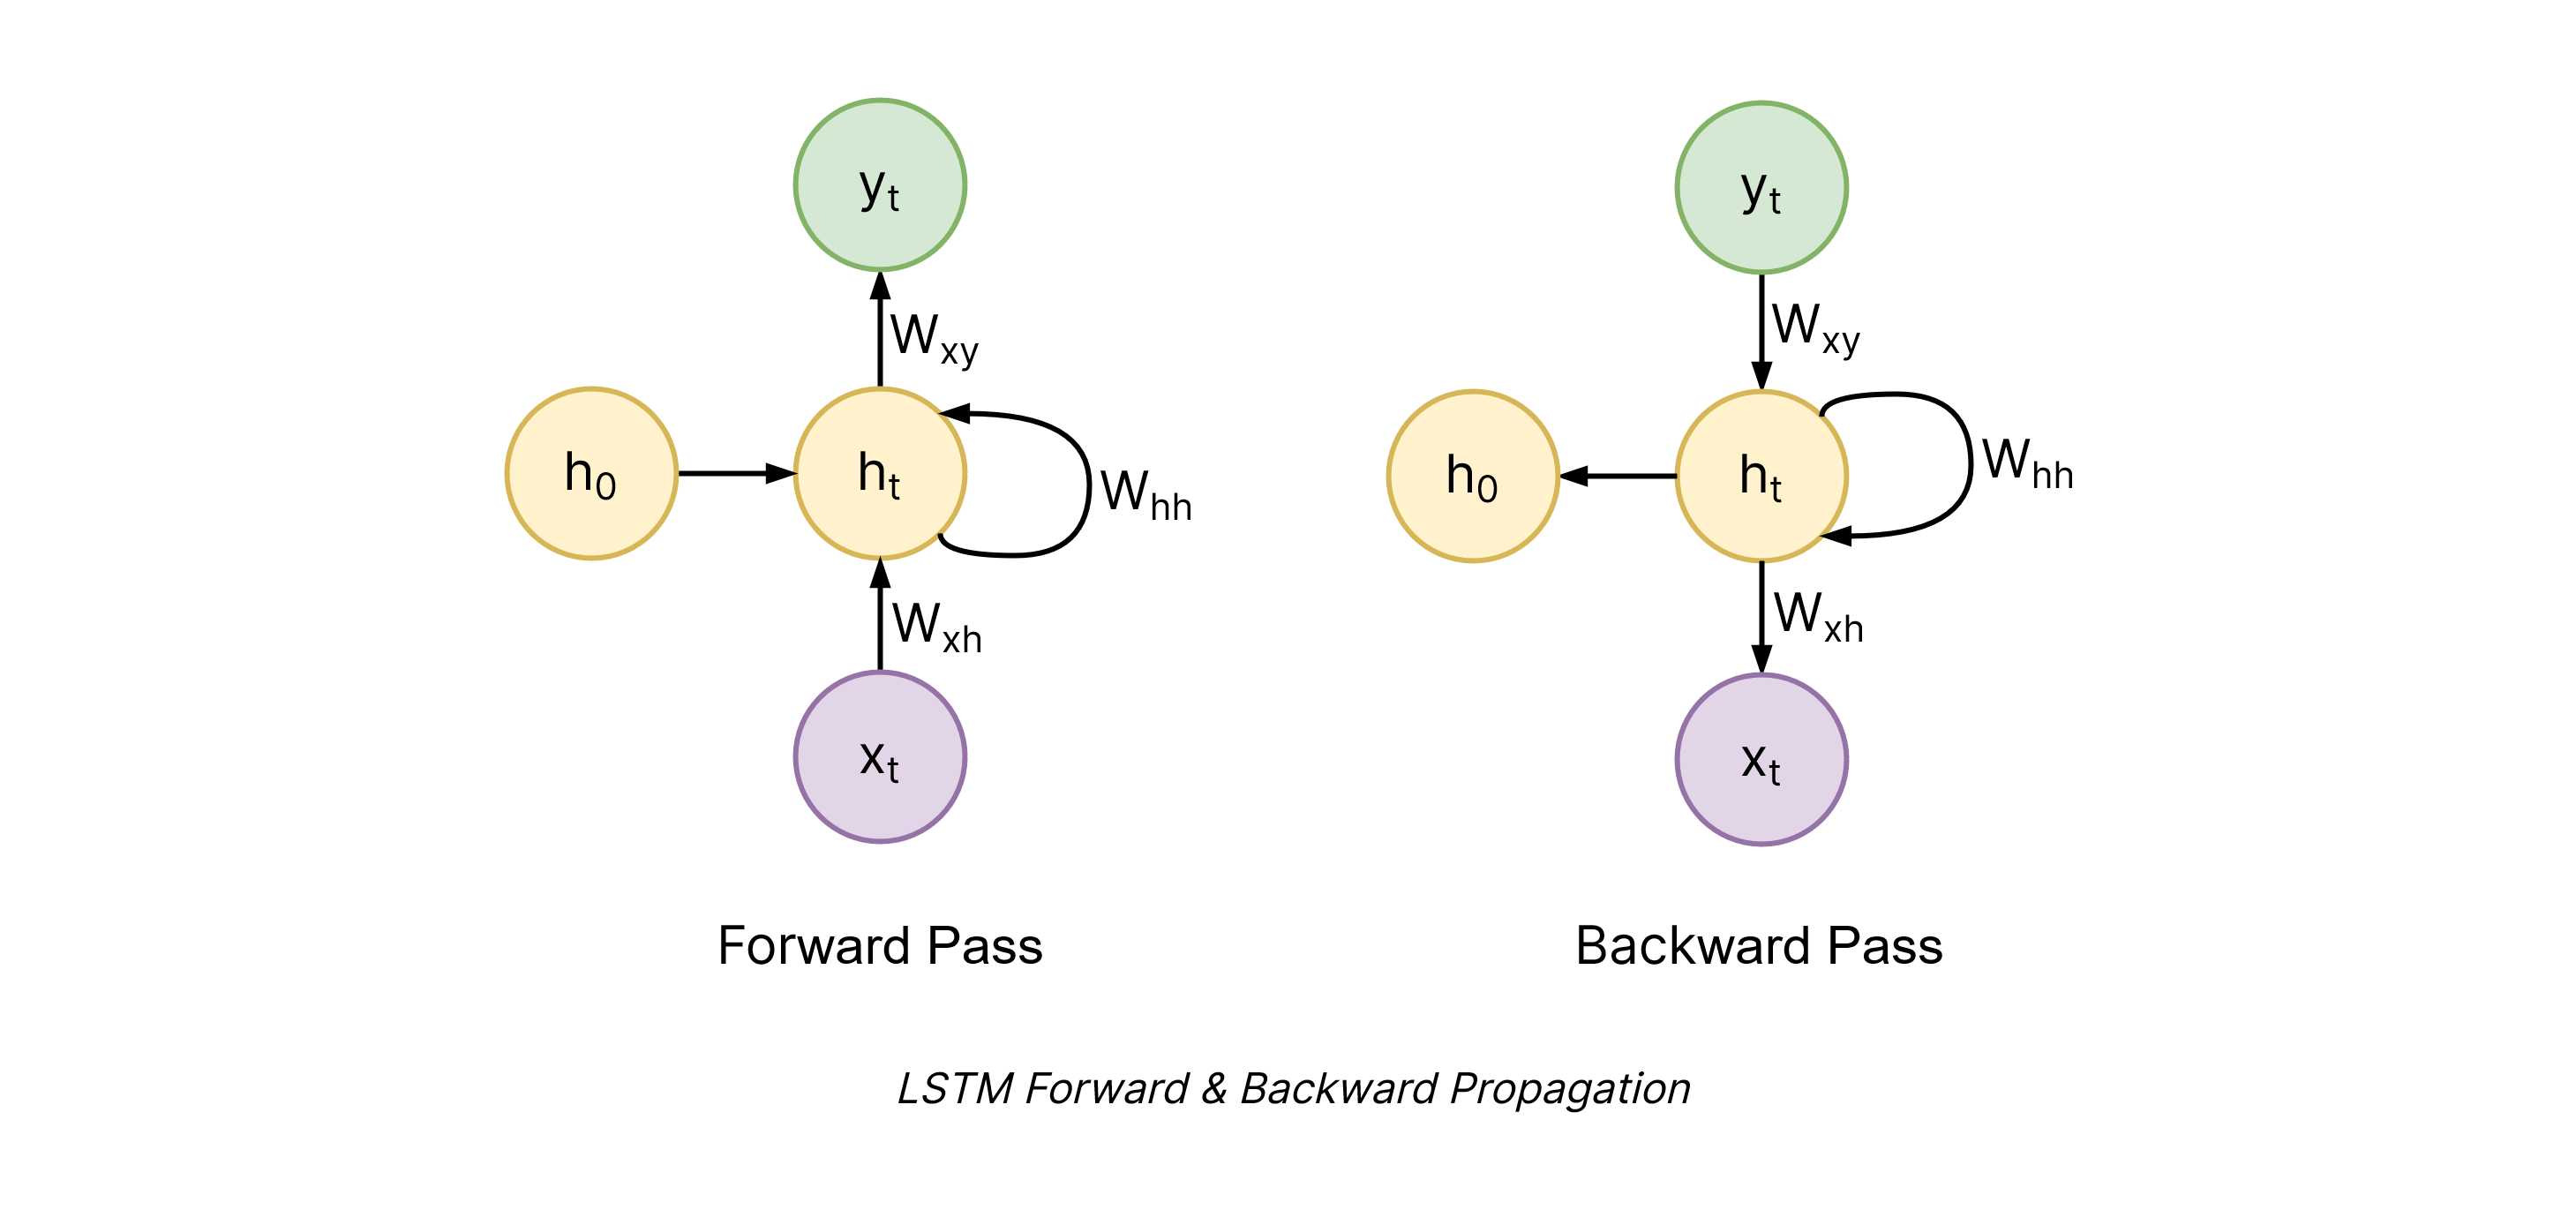


Các bước quan trọng trong quá trình huấn luyện mạng nơ-ron LSTM như sau:

1. **Chuyển tiếp (Forward Propagation)**:
   - Trong bước này, mạng LSTM xử lý dữ liệu đầu vào theo từng bước thời gian.
   - Tại mỗi bước thời gian $t$, LSTM lấy vector đầu vào $x_t$ và trạng thái ẩn trước đó $h_{t-1}$ để tính toán trạng thái ẩn hiện tại $h_t$ và đầu ra $y_t$.
   - Các phương trình cho bước chuyển tiếp trong một mạng LSTM bao gồm các hoạt động như tính toán các cổng (cổng đầu vào, cổng quên và cổng đầu ra), cập nhật trạng thái ô nhớ và tạo ra đầu ra dựa trên đầu vào hiện tại và trạng thái ẩn trước đó.

2. **Quay lui (Backpropagation Through Time)**:
   - Sau khi hoàn thành bước chuyển tiếp, hàm mất mát được tính dựa trên các đầu ra dự đoán ($y_1, y_2, ..., y_T$) và các nhãn thực tế (nếu có).
   - Quá trình lan truyền ngược qua thời gian (BPTT) được áp dụng để tính toán các gradient đối với các tham số của mô hình (ma trận trọng số và các thuật toán điều chỉnh).
   - Gradient được lan truyền ngược từ bước thời gian cuối cùng $T$ trở về bước thời gian 1.
   - BPTT bao gồm giải mã đồ thị tính toán của LSTM qua độ dài chuỗi, cho phép gradient lưu thông qua từng bước thời gian.

3. **Cập nhật Tham số**:
   - Sử dụng các gradient tính toán được từ quá trình lan truyền ngược, LSTM cập nhật các tham số của mình (ma trận trọng số $W_{xh}$, $W_{hh}$, $W_{hy}$, các độ lệch, v.v.) để giảm thiểu hàm mất mát.
   - Các tham số được cập nhật thông qua một thuật toán tối ưu hóa như gradient descent (ví dụ: gradient descent ngẫu nhiên, trình tối ưu hóa Adam).
   - Các trọng số được điều chỉnh theo hướng ngược của gradient để giảm thiểu hàm mất mát và cải thiện hiệu suất của mô hình theo thời gian.
   - Tốc độ học là một siêu tham số điều chỉnh kích thước các bước cập nhật trong quá trình tối ưu hóa tham số.

Tóm lại, quá trình huấn luyện một mạng LSTM bao gồm lặp lại các bước chuyển tiếp để tính toán các đầu ra, quay lui để tính toán các gradient và cập nhật các tham số của mô hình dựa trên các gradient này để giảm thiểu hàm mất mát huấn luyện. Mỗi bước là quan trọng để tối ưu hóa khả năng học các mẫu thời gian phức tạp và đưa ra các dự đoán chính xác cho các nhiệm vụ dữ liệu tuần tự.

# Initial Setups

## Initialize hyper-parameters

In [33]:
# Some hyper-parameters
hidden_size = 50
window_size = 12
training_start = 0.4
prediction_start = 0.8

## Import libraries

In [34]:
# Import libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import cuda

import warnings
from numba import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
np.random.seed(42)
plt.style.use('ggplot')

## Define functions

### General Functions

Hàm `load_dataset` có nhiệm vụ đọc dữ liệu từ tệp được chỉ định và thực hiện một số xử lý dữ liệu để chuẩn bị cho việc sử dụng trong các mô hình học máy. Hãy đi qua từng bước trong hàm này:

1. **Đọc dữ liệu và xóa cột không cần thiết**:
   - Hàm bắt đầu bằng việc đọc tệp dữ liệu từ đường dẫn `directory` sử dụng `pd.read_csv()`, sau đó gán DataFrame được đọc vào biến `df`.
   - Tiếp theo, cột 'Date' được loại bỏ khỏi DataFrame `df` bằng cách sử dụng `df.drop('Date', axis=1, inplace=True)`. Cột này có vẻ là không cần thiết cho mô hình dự đoán.

2. **Tính toán các cột mới**:
   - Cột 'Change' được tính bằng sự khác biệt giữa giá trị cổ phiếu tại thời điểm $t+1$ và $t$: `df['Change'] = df['ACB'].shift(-1) - df['ACB']`.
   - Các cột 'Upper_Bound' và 'Lower_Bound' được tính toán dựa trên độ dài của DataFrame `df`. Giá trị của 'Upper_Bound' là một chuỗi số tăng dần nhân với 0.5 và cộng thêm 15. Tương tự, 'Lower_Bound' là một chuỗi số giảm dần nhân với -0.6 và trừ đi 7. 

In [35]:
# Function: Load the main demo dataset
def load_dataset(directory, max_windows = 1):

    df = pd.read_csv(directory)

    df.drop('Date', axis=1, inplace=True)
    df['Change'] = df['ACB'].shift(-1) - df['ACB']
    df['Upper_Bound'] = [ 0.5 * x + 15 for x in range(len(df))]
    df['Lower_Bound'] = [-0.6 * x -  7 for x in range(len(df))]
    df.dropna(inplace=True)

    def change_normalized(row):
        if row['Change'] >= 0:
            return row['Change'] / row['Upper_Bound']
        else:
            return - row['Change'] / row['Lower_Bound']
    df['Change_Normalized'] = df.apply(change_normalized, axis=1)

    k = 3
    lst = df['Change_Normalized'].tolist()
    clusters, centroids = k_means_clustering(lst, k)
    devide_lines = []
    for i in range(len(centroids) - 1):
        devide_lines.append((centroids[i] + centroids[i+1]) / 2)

    def change_encoded(row):
        for i, line in enumerate(sorted(devide_lines)):
            if row['Change_Normalized'] < line:
                return i
        return len(devide_lines)
    df['Change_Encoded'] = df.apply(change_encoded, axis=1)

    # df['Change_Encoded'] -> sequences
    raw_data = [str(e) for e in df['Change_Encoded'].to_list()]
    sequences = []
    for i in range(len(raw_data) - window_size * max_windows):
        for u in range(max_windows):
            sequences.append(raw_data[i : i + window_size * (u+1)])
    print(sequences)

    return sequences, raw_data, df, centroids, devide_lines

Hàm `generate_dataset` được viết để tạo ra một tập dữ liệu thử nghiệm gồm các chuỗi ngẫu nhiên. Dưới đây là cách hoạt động của hàm này:

1. **Tham số của hàm**:
   - `num_sequences`: Số lượng chuỗi (sequences) muốn tạo ra trong tập dữ liệu. Mặc định là 50 nếu không được chỉ định.
   - `max_num_each_token`: Số lượng tokens tối đa (A, B, C) mà mỗi chuỗi có thể có. Mỗi token sẽ được lặp lại một số lần ngẫu nhiên từ 1 đến `max_num_each_token`.

2. **Tạo tập dữ liệu**:
   - Hàm bắt đầu bằng việc khởi tạo một danh sách rỗng `samples` để lưu trữ các chuỗi.
   - Sau đó, vòng lặp `for` chạy qua số lượng `num_sequences` được chỉ định. Trong mỗi lần lặp, hàm tạo ra một chuỗi ngẫu nhiên:
     - `num_tokens` là số ngẫu nhiên được chọn trong khoảng từ 1 đến `max_num_each_token`.
     - `sample` được khởi tạo bằng cách nối các list chứa các token 'A', 'B', 'C' được lặp lại `num_tokens` lần, và sau đó thêm vào token 'EOS' (End of Sequence) để chỉ kết thúc của chuỗi.
     - Chuỗi được tạo thành bằng cách nối các list token lại với nhau.
   - Cuối cùng, chuỗi được thêm vào danh sách `samples`.

3. **Trả về kết quả**:
   - Kết quả trả về là danh sách `samples` chứa `num_sequences` chuỗi ngẫu nhiên. Mỗi chuỗi trong `samples` là một danh sách các tokens ('A', 'B', 'C') kết thúc bằng 'EOS'.

Ví dụ:
Nếu gọi `generate_dataset(num_sequences=3, max_num_each_token=4)`, kết quả có thể là:
```
[['A', 'B', 'B', 'B', 'C', 'C', 'C', 'EOS'],
 ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'EOS'],
 ['A', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'EOS']]
```
Các chuỗi được tạo ra ngẫu nhiên, số lượng tokens (A, B, C) trong mỗi chuỗi cũng là ngẫu nhiên và có thể khác nhau.

In [36]:
# Function: Generate a quick test dataset
def generate_dataset(num_sequences = 50, max_num_each_token = 5):
    samples = []
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, max_num_each_token)
        sample = ['A'] * num_tokens + ['B'] * num_tokens + ['C'] * num_tokens + ['EOS']
        samples.append(sample)
    return samples

Hàm `sequences_to_dicts` được viết để chuyển đổi danh sách các chuỗi thành các từ điển (`word_to_idx`, `idx_to_word`) và trả về một số thông tin khác về tập dữ liệu.

**Cách hoạt động của hàm**:

1. **Tạo danh sách từ** (`all_words`):
   - Đầu tiên, danh sách `sequences` được làm phẳng thành một danh sách duy nhất `all_words` sử dụng hàm lambda `flatten`.
   
2. **Đếm số lần xuất hiện của mỗi từ** (`word_count`):
   - Một từ điển `word_count` được tạo để đếm số lần xuất hiện của mỗi từ trong `all_words`.
   - Vòng lặp đầu tiên đi qua `all_words` để thiết lập mỗi từ ban đầu với số lần xuất hiện là 0.
   - Vòng lặp thứ hai tính toán số lần xuất hiện thực sự của mỗi từ bằng cách tăng giá trị tương ứng trong `word_count` lên 1 cho mỗi từ.

3. **Sắp xếp các từ theo tần suất xuất hiện** (`word_count`):
   - Danh sách `word_count` được sắp xếp theo số lần xuất hiện của từ (từ cao đến thấp) bằng cách sử dụng hàm `sorted` với tham số `key=lambda l: -l[1]`, để sắp xếp theo thứ tự giảm dần của số lần xuất hiện.

4. **Tạo danh sách các từ duy nhất** (`unique_words`):
   - Danh sách `unique_words` được tạo bằng cách lấy các từ duy nhất từ danh sách `word_count` đã được sắp xếp.

5. **Tính toán số câu (`num_sentences`) và kích thước từ vựng (`vocab_size`)**:
   - `num_sentences` được đặt bằng độ dài của danh sách `sequences` (số lượng chuỗi).
   - `vocab_size` là số lượng từ duy nhất trong `unique_words`.

6. **Tạo từ điển `word_to_idx` và `idx_to_word`**:
   - Duyệt qua danh sách `unique_words` và gán mỗi từ một chỉ số (index) trong `word_to_idx` và ngược lại trong `idx_to_word`.

7. **Trả về kết quả**:
   - Hàm trả về `word_to_idx` (từ điển từ điển từ => chỉ số), `idx_to_word` (từ điển chỉ số => từ), `num_sentences` (số lượng chuỗi) và `vocab_size` (kích thước từ vựng).

**Lưu ý**:
- Hàm này sử dụng một phương pháp đơn giản để tạo các từ điển và tính toán thông tin về tập dữ liệu dựa trên các chuỗi được cung cấp. Nó không xử lý các trường hợp đặc biệt như xử lý ký tự đặc biệt hay chữ viết hoa/thường khác nhau, nên tùy chỉnh cần được áp dụng nếu cần thiết.

In [37]:
# Function: List of sequences -> word_to_idx, idx_to_word, num_sentences, vocab_size
def sequences_to_dicts(sequences):
    flatten = lambda l: [item for sublist in l for item in sublist] # Flatten a nested list
    all_words = flatten(sequences)
    # Count number of word occurences
    word_count = {}
    for word in flatten(sequences):
        word_count[word] = 0
    for word in flatten(sequences):
        word_count[word] = word_count[word] + 1
    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)
    # Create dictionaries so that we can go from word to index and back
    word_to_idx = {}
    idx_to_word = {}
    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    return word_to_idx, idx_to_word, num_sentences, vocab_size

Các hàm `create_datasets`, `create_actual_and_predicted_df`, và `calculate_rmse` được viết để thực hiện các công việc khác nhau liên quan đến việc chia tập dữ liệu, tạo DataFrame cho dự đoán thực tế và tính toán Root Mean Square Error (RMSE) cho các dự đoán.

**Hàm `create_datasets`**:
- **Tham số đầu vào**:
  - `sequences`: Danh sách các chuỗi (sequences) được chuyển đến từ tập dữ liệu.
  - `p_train`, `p_val`, `p_test`: Tỷ lệ phần trăm dữ liệu được sử dụng cho tập huấn luyện (Train), tập validation (Val), và tập kiểm thử (Test) tương ứng. Mặc định là 0.8 (80%) cho tập train, 0.1 (10%) cho tập validation và 0.1 (10%) cho tập test.
- **Công việc**:
  - Tính toán số lượng mẫu trong tập train, tập validation và tập test dựa trên tỷ lệ được cung cấp.
  - Chia các chuỗi ban đầu thành các tập train, validation và test.
  - Xác định inputs và targets từ các chuỗi trong mỗi tập.
  - Tạo ra các tập dữ liệu (datasets) dưới dạng cặp (inputs, targets) cho từng tập (train, validation, test).
- **Đầu ra**:
  - `training_set`, `validation_set`, `test_set`: Các datasets chứa các cặp (inputs, targets) cho từng tập tương ứng.

**Hàm `create_actual_and_predicted_df`**:
- **Tham số đầu vào**:
  - `df`: DataFrame chứa dữ liệu thực tế và dự đoán của một biến.
- **Công việc**:
  - Tạo DataFrame mới (`actual_and_predicted`) chứa cột 'Actual' (dữ liệu thực tế) và 'Predicted' (dự đoán) từ DataFrame ban đầu (`df`).
  - Dịch chuyển cột 'Actual' xuống 30 đơn vị.
  - Loại bỏ các hàng chứa giá trị `NaN` trong DataFrame mới.
- **Đầu ra**:
  - `actual_and_predicted`: DataFrame mới chứa các cột 'Actual' và 'Predicted' đã được xử lý.

**Hàm `calculate_rmse`**:
- **Tham số đầu vào**:
  - `predictions`: Mảng numpy chứa các giá trị dự đoán.
  - `targets`: Mảng numpy chứa các giá trị thực tế.
- **Công việc**:
  - Tính toán Mean Squared Error (MSE) bằng cách lấy trung bình bình phương của sự khác biệt giữa các dự đoán và các giá trị thực tế.
  - Tính toán RMSE (căn bậc hai của MSE) dựa trên giá trị MSE đã tính.
- **Đầu ra**:
  - `rmse`: Giá trị RMSE cho các dự đoán so với các giá trị thực tế.

Các hàm này là những bước quan trọng để chuẩn bị dữ liệu, đánh giá các dự đoán và tính toán độ lỗi của mô hình. Bạn có thể sử dụng các hàm này trong quá trình huấn luyện và đánh giá mô hình của mình trên dữ liệu thực tế.

In [38]:
# Function: Create and split dataset into Train/Val/Test set
def create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1):
    # Train/Val/Test ratio
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)
    # Split sequences into Train/Val/Test
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]
    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
        return inputs, targets
    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
    # Create datasets
    training_set = [(inputs_train[i], targets_train[i]) for i in range(len(inputs_train))]
    validation_set = [(inputs_val[i], targets_val[i]) for i in range(len(inputs_val))]
    test_set = [(inputs_test[i], targets_test[i]) for i in range(len(inputs_test))]    
    return training_set, validation_set, test_set

def create_actual_and_predicted_df(df):
    actual_and_predicted = pd.DataFrame({
        'Actual': df['ACB'][int(prediction_start * len(df))-1 : -1].shift(-1), 
        'Predicted': df['ACB_Prediction'][int(prediction_start * len(df))-2 : -2],
    })
    actual_and_predicted['Actual'] = actual_and_predicted['Actual'] - 30
    actual_and_predicted.dropna(inplace=True)
    return actual_and_predicted

def calculate_rmse(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    return rmse


Hàm `is_rmse_good` được viết để xác định xem giá trị RMSE có được coi là tốt dựa trên một quy tắc đơn giản:

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `rmse`: Giá trị của Root Mean Square Error (RMSE) mà bạn muốn đánh giá.
  - `target_variable`: Mảng hoặc chuỗi chứa các giá trị của biến mục tiêu (target variable), dùng để tính toán ngưỡng (threshold) dựa trên phạm vi (range) hoặc độ lệch chuẩn (standard deviation) của biến mục tiêu.
- **Công việc**:
  - Tính toán ngưỡng (threshold) bằng cách lấy 10% của phạm vi (range) của `target_variable` (tức là 10% của `np.max(target_variable) - np.min(target_variable)`). Mục đích là xác định ngưỡng RMSE mà nó nên nhỏ hơn để được coi là tốt.
  - So sánh giá trị RMSE với ngưỡng được tính toán. Nếu RMSE nhỏ hơn ngưỡng, hàm trả về `True`, ngược lại trả về `False`.
- **Đầu ra**:
  - `True` nếu RMSE được coi là tốt (nhỏ hơn ngưỡng), `False` nếu không.

**Lưu ý**:
- Phương pháp tính toán ngưỡng (threshold) có thể được thay đổi bằng cách sử dụng 10% của độ lệch chuẩn (standard deviation) của `target_variable` (`0.1 * np.std(target_variable)`) thay vì 10% của phạm vi (range). Cách tính này sẽ phụ thuộc vào dạng phân phối của `target_variable`.
- Hàm `is_rmse_good` giúp xác định liệu giá trị RMSE có đạt yêu cầu (tốt) theo quy tắc được đề xuất hay không. Nó có thể được sử dụng để đánh giá hiệu suất của mô hình dựa trên giá trị RMSE và tính toán của biến mục tiêu.

In [39]:
# Determines if the RMSE is considered good based on the rule:
# RMSE should be less than 10% of the range or standard deviation of the target variable.
def is_rmse_good(rmse, target_variable):
    threshold = 0.1 * (np.max(target_variable) - np.min(target_variable)) # Alternatively: 0.1 * np.std(target_variable)
    if rmse < threshold:
        return True
    else:
        return False

### One-hot Encoding Functions

Hàm `one_hot_encode` được viết để thực hiện mã hóa one-hot cho một chỉ số (index) trong một không gian từ vựng (vocabulary) cho các tác vụ liên quan đến xử lý ngôn ngữ tự nhiên và mạng nơ-ron.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `idx`: Chỉ số (index) của từ trong không gian từ vựng (vocabulary) mà bạn muốn mã hóa one-hot.
  - `vocab_size`: Kích thước của không gian từ vựng (vocabulary), tức là số lượng từ khác nhau có thể có.
- **Công việc**:
  - Khởi tạo một mảng numpy `one_hot` có kích thước bằng `vocab_size`, và tất cả các phần tử được đặt về 0.0 ban đầu.
  - Đặt phần tử tại chỉ số `idx` của mảng `one_hot` thành 1.0 để thực hiện mã hóa one-hot cho từ tương ứng.
- **Đầu ra**:
  - Mảng numpy `one_hot` đã được mã hóa one-hot cho chỉ số `idx` trong không gian từ vựng có kích thước `vocab_size`.


In [40]:
# Function: One-hot encoding a Token
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1.0
    return one_hot

Hàm `one_hot_encode_sequence` được viết để thực hiện mã hóa one-hot cho một chuỗi (sequence) các token trong một không gian từ vựng (vocabulary) đã cho.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `sequence`: Danh sách các token (các từ) trong chuỗi mà bạn muốn mã hóa one-hot.
  - `vocab_size`: Kích thước của không gian từ vựng (vocabulary), tức là số lượng từ khác nhau có thể có.
- **Công việc**:
  - Sử dụng hàm `one_hot_encode` để mã hóa one-hot cho từng token trong `sequence`. Đối với mỗi từ trong `sequence`, hàm `one_hot_encode` sẽ trả về một vector one-hot có kích thước `vocab_size` đại diện cho từ đó.
  - Tạo một mảng numpy (`encoding`) bằng cách xếp các vector one-hot này (cho mỗi từ) theo chiều dọc (theo hàng).
  - Sau đó, sắp xếp lại hình dạng của `encoding` để có kích thước chính xác, tức là `(số lượng token trong sequence, vocab_size, 1)`. Điều này là cần thiết cho việc sử dụng dữ liệu này trong các mạng nơ-ron như mạng LSTM.
- **Đầu ra**:
  - Mảng numpy `encoding` có hình dạng `(số lượng token trong sequence, vocab_size, 1)`, trong đó mỗi token trong `sequence` đã được mã hóa one-hot và được biểu diễn bằng một vector one-hot có kích thước `vocab_size`.


In [41]:
# Function: One-hot encoding a Sequence (list of tokens)
def one_hot_encode_sequence(sequence, vocab_size):
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

Hàm `one_hot_encode_set` được viết để thực hiện mã hóa one-hot cho các tập dữ liệu huấn luyện (training_set), validation (validation_set), và test (test_set) trong một không gian từ vựng (vocabulary) đã cho.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `training_set`, `validation_set`, `test_set`: Các tập dữ liệu chứa các cặp (inputs, targets) của các tập tương ứng.
  - `vocab_size`: Kích thước của không gian từ vựng (vocabulary), tức là số lượng từ khác nhau có thể có.
- **Công việc**:
  - Duyệt qua từng cặp (inputs, targets) trong `training_set`, `validation_set`, và `test_set`.
  - Đối với mỗi cặp (inputs, targets), sử dụng hàm `one_hot_encode_sequence` để mã hóa one-hot cho cả inputs và targets trong cặp này.
  - Lưu trữ các cặp (inputs_one_hot, targets_one_hot) đã được mã hóa one-hot vào các danh sách tương ứng (`training_set_one_hot`, `validation_set_one_hot`, `test_set_one_hot`).
  - Trả về các tập dữ liệu (`training_set_one_hot`, `validation_set_one_hot`, `test_set_one_hot`) sau khi đã được mã hóa one-hot.
- **Đầu ra**:
  - Ba tập dữ liệu đã được mã hóa one-hot: `training_set_one_hot`, `validation_set_one_hot`, `test_set_one_hot`, mỗi tập là một danh sách các cặp (inputs_one_hot, targets_one_hot) đã được mã hóa one-hot.

**Lưu ý**:
- Hàm này chuyển đổi các tập dữ liệu ban đầu (inputs, targets) thành các tập dữ liệu mới (`*_one_hot`) trong đó inputs và targets đã được mã hóa one-hot.
- Kết quả của hàm này là các tập dữ liệu đã được mã hóa one-hot sẵn sàng để sử dụng trong việc huấn luyện các mô hình mạng nơ-ron, đặc biệt là các mô hình như LSTM trong các tác vụ xử lý ngôn ngữ tự nhiên.

In [42]:
# Function: One-hot encoding Train/Val/Test sets
def one_hot_encode_set(training_set, validation_set, test_set, vocab_size):
    training_set_one_hot = []
    validation_set_one_hot = []
    test_set_one_hot = []
    for idx, (inputs, targets) in enumerate(training_set):
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        training_set_one_hot.append((inputs_one_hot, targets_one_hot))
    for idx, (inputs, targets) in enumerate(validation_set):
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        validation_set_one_hot.append((inputs_one_hot, targets_one_hot))
    for idx, (inputs, targets) in enumerate(test_set):
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        test_set_one_hot.append((inputs_one_hot, targets_one_hot))
    training_set_one_hot = tuple(training_set_one_hot)
    validation_set_one_hot = tuple(validation_set_one_hot)
    test_set_one_hot = tuple(test_set_one_hot)
    return training_set_one_hot, validation_set_one_hot, test_set_one_hot

In [43]:
# Function: Help initializing parameters
def randn(x, y):
  return np.array([[0.5 if (u+i)%2==0 else -0.5 for u in range(y)] for i in range(x)])

Hàm `k_means_clustering(lst, k)` được viết để thực hiện thuật toán đơn giản K-Means để tìm các trung tâm (centroids) của các điểm dữ liệu.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `lst`: Danh sách các điểm dữ liệu mà bạn muốn phân cụm bằng thuật toán K-Means.
  - `k`: Số lượng cụm (clusters) bạn muốn tìm.
- **Công việc**:
  - Khởi tạo các centroids ban đầu bằng cách lấy `k` điểm đầu tiên từ danh sách `lst`.
  - Khởi tạo các clusters ban đầu là một danh sách chứa `k` danh sách con rỗng.
  - Lặp cho đến khi không có sự thay đổi nào trong các clusters:
    - Khởi tạo `new_clusters` là một danh sách chứa `k` danh sách con rỗng.
    - Duyệt qua từng điểm `num` trong danh sách `lst`:
      - Tính khoảng cách từ `num` đến mỗi centroid và tìm chỉ số của centroid gần nhất (có khoảng cách nhỏ nhất).
      - Thêm `num` vào cluster tương ứng với centroid gần nhất.
    - Nếu `new_clusters` giống với `clusters` (không có sự thay đổi nào), thì dừng vòng lặp.
    - Cập nhật `clusters` thành `new_clusters`.
    - Cập nhật các centroids mới bằng cách tính trung bình của từng cluster.
- **Đầu ra**:
  - `clusters`: Danh sách chứa `k` clusters sau khi thuật toán K-Means hoàn thành.
  - `centroids`: Danh sách chứa `k` centroids tương ứng với các clusters.


In [44]:
# Funciton: Simple K-Means to find centroids of data points
def k_means_clustering(lst, k):
    centroids = sorted(lst)[:k]
    clusters = [[] for _ in range(k)]
    while True:
        new_clusters = [[] for _ in range(k)]
        for num in lst:
            distances = [abs(num - centroid) for centroid in centroids]
            closest_centroid_index = distances.index(min(distances))
            new_clusters[closest_centroid_index].append(num)
        if new_clusters == clusters:
            break
        clusters = new_clusters
        centroids = [sum(cluster) / len(cluster) for cluster in clusters]
    return clusters, centroids


In [45]:
# Function: Print some basic information about the dataset
def print_data_basic_info(sequences, num_sequences, vocab_size, word_to_idx, idx_to_word, training_set, validation_set, test_set):
    print(f"Example sequence: {sequences[0]}\n")
    print(f"Num of sequences (Dataset size):\t{num_sequences} sequences")
    print(f"Num of tokens (Vocab size):\t\t{vocab_size} tokens")
    print("\nword_to_idx:")
    for item in word_to_idx:
      print(f"'{item}' -> {word_to_idx[item]}")
    print("\nidx_to_word:")
    for item in idx_to_word:
      print(f"{item} -> '{idx_to_word[item]}'")
    print(f"\nDataset splitting:")
    print(f'Train:\t\t{len(training_set)} samples')
    print(f'Validation:\t{len(validation_set)} samples')
    print(f'Test:\t\t{len(test_set)} samples')

### Activation Functions

Đây là một tập hợp các hàm kích hoạt thông dụng được sử dụng trong mạng nơ-ron:

1. **Hàm Sigmoid** (`sigmoid`):
   - **Công thức**: $$ \text{sigmoid}(x) = \frac{1}{1 + e^{-x}} $$
   - **Đạo hàm**: 
      $$ \text{sigmoid}'(x) = \text{sigmoid}(x) \cdot (1 - \text{sigmoid}(x)) $$
   - **Tham số**:
     - `x`: Đầu vào của hàm sigmoid.
     - `derivative`: Nếu là True, trả về đạo hàm của hàm sigmoid tại `x`, ngược lại trả về giá trị của hàm sigmoid tại `x`.
   
2. **Hàm Tanh** (`tanh`):
   - **Công thức**: $$ \text{tanh}(x) = \frac{{e^x - e^{-x}}}{{e^x + e^{-x}}} $$
   - **Đạo hàm**: $$ \text{tanh}'(x) = 1 - \text{tanh}^2(x) $$
   - **Tham số**:
     - `x`: Đầu vào của hàm tanh.
     - `derivative`: Nếu là True, trả về đạo hàm của hàm tanh tại `x`, ngược lại trả về giá trị của hàm tanh tại `x`.

3. **Hàm Softmax** (`softmax`):
   - **Công thức**: \( \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}} \) với \( N \) là số lượng phần tử trong vector \( x \).
   - **Đạo hàm**: Đạo hàm của hàm softmax có thể được tính trong quá trình tính toán gradient của hàm mất mát.
   - **Tham số**:
     - `x`: Vector đầu vào của hàm softmax.
     - `derivative`: Nếu là True, không trả về giá trị. (Đạo hàm của hàm softmax được tính trong quá trình tính toán gradient của hàm mất mát).

Mỗi hàm kích hoạt có tham số `derivative` để cho phép tính toán đạo hàm của hàm kích hoạt đó tại một điểm xác định. Điều này hữu ích trong quá trình lan truyền ngược (backpropagation) để cập nhật trọng số của mạng nơ-ron trong quá trình huấn luyện.

In [46]:
# Activation Function: Sigmoid
def sigmoid(x, derivative=False):
    if derivative:
        return (1 / (1 + np.exp(- x - 1e-12))) * (1 - (1 / (1 + np.exp(- x - 1e-12))))
    else:
        return 1 / (1 + np.exp(- x - 1e-12))

# Activation Function: Tanh
def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    if derivative:
        return 1-f**2
    else:
        return f

# Activation Function: Softmax
def softmax(x, derivative=False):
    if derivative:
        pass
    else:
        return np.exp(x + 1e-12) / np.sum(np.exp(x + 1e-12))

### Neural Network Functions

Hàm `init_orthogonal(param)` được viết để khởi tạo ma trận tham số của mạng nơ-ron theo phương pháp Orthogonal Initialization.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `param`: Ma trận tham số của mạng nơ-ron, được lấy từ layer cần khởi tạo.
- **Công việc**:
  - Kiểm tra kích thước của `param` để đảm bảo chỉ khởi tạo cho các ma trận có 2 chiều trở lên.
  - Xây dựng một ma trận ngẫu nhiên `new_param` có cùng kích thước với `param` bằng cách sử dụng hàm `randn` đã định nghĩa trước đó.
  - Nếu số hàng của `new_param` nhỏ hơn số cột (mà `cols` > `rows`), chuyển vị của `new_param` để đảm bảo số chiều của ma trận có cấu trúc phù hợp.
  - Áp dụng phương pháp Orthogonal Initialization bằng cách sử dụng phép phân tích QR (`np.linalg.qr`) để phân rã `new_param` thành một ma trận `q` và một ma trận tam giác trên (`r`).
  - Điều chỉnh dấu của các phần tử trên đường chéo chính (`np.diag(r, 0)`) để chắc chắn rằng ma trận `q` thu được là ma trận Orthogonal (có các cột đơn vị trực giao).
  - Trả về ma trận `new_param` đã được khởi tạo theo phương pháp Orthogonal Initialization.
- **Đầu ra**:
  - `new_param`: Ma trận tham số đã được khởi tạo theo phương pháp Orthogonal Initialization, có cùng kích thước với `param`.

**Lưu ý**:
- Phương pháp Orthogonal Initialization nhằm đảm bảo rằng các ma trận tham số của mạng nơ-ron được khởi tạo sao cho không gian biểu diễn của các đặc trưng là độc lập và dễ dàng cho quá trình học của mạng nơ-ron.
- Việc sử dụng hàm này để khởi tạo các ma trận tham số của mạng nơ-ron giúp cải thiện hiệu suất và độ tin cậy của mô hình trong quá trình huấn luyện.

In [47]:
# Function: Initialize the neural network
def init_orthogonal(param):
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")
    rows, cols = param.shape
    new_param = randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    return new_param

Hàm `init_lstm(hidden_size, vocab_size)` được viết để khởi tạo các ma trận tham số của mạng LSTM (Long Short-Term Memory).

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `hidden_size`: Kích thước của không gian ẩn (hidden state) trong mạng LSTM.
  - `vocab_size`: Kích thước của không gian từ vựng (vocabulary), tức là số lượng từ khác nhau có thể có.
- **Công việc**:
  - Khởi tạo các ma trận tham số cho mạng LSTM bao gồm:
    - `U`: Ma trận trọng số của đầu vào tại cổng đầu vào (input gate).
    - `V`: Ma trận trọng số của trạng thái ẩn trước đó tại cổng quên (forget gate).
    - `W`: Ma trận trọng số của trạng thái ẩn trước đó tại cổng đầu ra (output gate).
    - `b_hidden`: Vector bias cho trạng thái ẩn.
    - `b_out`: Vector bias cho đầu ra.
  - Sử dụng hàm `init_orthogonal` để khởi tạo các ma trận `U`, `V`, `W` theo phương pháp Orthogonal Initialization.
- **Đầu ra**:
  - Bốn ma trận tham số của mạng LSTM sau khi được khởi tạo.
    - `U`: Ma trận trọng số của đầu vào tại cổng đầu vào.
    - `V`: Ma trận trọng số của trạng thái ẩn trước đó tại cổng quên.
    - `W`: Ma trận trọng số của trạng thái ẩn trước đó tại cổng đầu ra.
    - `b_hidden`: Vector bias cho trạng thái ẩn.
    - `b_out`: Vector bias cho đầu ra.

**Lưu ý**:
- Các ma trận `U`, `V`, `W` được khởi tạo theo phương pháp Orthogonal Initialization để đảm bảo tính khả dụng và tính hiệu quả của mạng LSTM trong quá trình huấn luyện.
- Hàm `init_lstm` là một bước quan trọng trong việc khởi tạo mạng LSTM trước khi bắt đầu quá trình huấn luyện và sử dụng mạng này để xử lý dữ liệu chuỗi.

In [48]:
# Function: Initialize the LSTM network
def init_lstm(hidden_size, vocab_size):
    U = np.zeros((hidden_size, vocab_size))
    V = np.zeros((hidden_size, hidden_size))
    W = np.zeros((vocab_size, hidden_size))
    b_hidden = np.zeros((hidden_size, 1))
    b_out = np.zeros((vocab_size, 1))
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    return U, V, W, b_hidden, b_out

Các hàm được mô tả sau đây là các thành phần chính của một mạng LSTM (Long Short-Term Memory). Dưới đây là mô tả của từng hàm:

##### Hàm `update_parameters(params, grads, lr)`
- **Công việc**: Cập nhật các tham số của mạng sử dụng Gradient Descent.
- **Tham số**:
  - `params`: Danh sách các tham số của mạng.
  - `grads`: Danh sách các gradient của từng tham số tương ứng.
  - `lr`: Tốc độ học (learning rate).
- **Đầu ra**: Trả về danh sách các tham số sau khi được cập nhật.

##### Hàm `forward_pass(inputs, h, U, V, W, B, b_out, outputs, h_s)`
- **Công việc**: Thực hiện quá trình lan truyền tiến (forward pass) của mạng LSTM.
- **Tham số**:
  - `inputs`: Danh sách các đầu vào (input sequence).
  - `h`: Trạng thái ẩn (hidden state) ban đầu.
  - `U`, `V`, `W`: Các ma trận trọng số của mạng LSTM.
  - `B`: Bias cho phần lan truyền tiến.
  - `b_out`: Bias cho đầu ra.
  - `outputs`: Danh sách để lưu trữ các đầu ra của mạng.
  - `h_s`: Danh sách để lưu trữ các trạng thái ẩn của mạng.
- **Đầu ra**: Trả về danh sách các đầu ra của mạng và danh sách các trạng thái ẩn.

##### Hàm `backward_pass(inputs, outputs, h_s, targets, V, W, d_U, d_V, d_W, d_B, d_h_next)`
- **Công việc**: Thực hiện quá trình lan truyền ngược (backward pass) của mạng LSTM.
- **Tham số**:
  - `inputs`: Danh sách các đầu vào (input sequence).
  - `outputs`: Danh sách các đầu ra của mạng.
  - `h_s`: Danh sách các trạng thái ẩn của mạng.
  - `targets`: Danh sách các đầu ra mong đợi.
  - `V`, `W`: Các ma trận trọng số của mạng LSTM.
  - `d_U`, `d_V`, `d_W`, `d_B`: Các gradient của các ma trận trọng số và bias.
  - `d_h_next`: Gradient của trạng thái ẩn tiếp theo.
- **Đầu ra**: Trả về giá trị tổn thất (loss) và các gradient của các ma trận trọng số và bias.

##### Các lưu ý:
- Hàm `update_parameters` thực hiện việc cập nhật các tham số của mạng bằng cách sử dụng gradient descent với tốc độ học là `lr`.
- Hàm `forward_pass` và `backward_pass` lần lượt thực hiện các quá trình lan truyền tiến và lan truyền ngược của mạng LSTM để tính toán đầu ra và gradient.
- Trong quá trình lan truyền ngược (`backward_pass`), các gradient được tính toán để cập nhật các tham số của mạng.
- Các hàm này là các thành phần cơ bản của một mạng LSTM và thường được sử dụng trong quá trình huấn luyện và đánh giá mô hình. Lưu ý rằng việc triển khai mạng LSTM đầy đủ và hiệu quả đòi hỏi nhiều bước và phức tạp hơn những gì đã được thể hiện ở đây.

In [49]:
# Function: Update parameters of the network
def update_parameters(params, grads, lr):
    for param, grad in zip(params, grads):
        param -= lr * grad * 10
    return params

# Function: LSTM Forward Pass
def forward_pass(inputs, h, U, V, W, B, b_out, outputs, h_s):
    for idf in range(len(inputs)):
        h = tanh(np.dot(U, inputs[idf]) + np.dot(V, h) + B)
        h_s[idf] = h
        outputs[idf] = softmax(np.dot(W, h) + b_out)
    return outputs, h_s

# Function: LSTM Backward Pass
def backward_pass(inputs, outputs, h_s, targets, V, W, d_U, d_V, d_W, d_B, d_h_next):
    loss = 0
    for idb_r in range(hidden_size):
        d_h_next[idb_r][0] = 0
    for idb in reversed(range(len(inputs))):
        loss = loss - np.mean(np.log(outputs[idb]+1e-12) * targets[idb])
        outputs[idb][np.argmax(targets[idb])] = outputs[idb][np.argmax(targets[idb])] - 1
        d_f = tanh(h_s[idb], derivative=True) * (np.dot(W.T, outputs[idb]) + d_h_next)
        d_h_next = np.dot(V.T, d_f)
        d_U = d_U + np.dot(d_f, inputs[idb].T)
        if idb != 0:
            d_V = d_V + np.dot(d_f, h_s[idb-1].T)
        elif idb == 0:
            d_V = d_V + np.dot(d_f, h_s[len(inputs)-1].T)
        d_W = d_W + np.dot(outputs[idb], h_s[idb].T)
        d_B = d_B + d_f
    clip_coef = 0.25 / (np.sqrt(np.sum(np.power(d_U, 2)) + np.sum(np.power(d_V, 2)) + np.sum(np.power(d_W, 2)) + np.sum(np.power(d_B, 2))) + 1e-6)
    if clip_coef < 1:
        d_U = d_U * clip_coef
        d_V = d_V * clip_coef
        d_W = d_W * clip_coef
        d_B = d_B * clip_coef
    return loss, d_U, d_V, d_W, d_B

# # ----- Testing Area -----
# params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size)
# test_input_sequence, test_target_sequence = training_set[0]
# test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
# test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)
# hidden_state = np.zeros((hidden_size, 1))
# U, V, W, B, b_out = params
# d_U_TEMP = np.zeros((hidden_size, vocab_size))
# d_V_TEMP = np.zeros((hidden_size, hidden_size))
# d_W_TEMP = np.zeros((vocab_size, hidden_size))
# d_B_TEMP = np.zeros((hidden_size, 1))
# d_h_next_TEMP = np.zeros((hidden_size, 1))
# outputs = np.zeros((len(test_input), vocab_size, 1))
# h_s = np.zeros((len(test_input), hidden_size, 1))
# outputs, hidden_states = forward_pass(test_input, hidden_state, U, V, W, B, b_out, outputs, h_s)
# loss, _, _, _, _ = backward_pass(test_input, outputs, hidden_states, test_target, V, W, d_U_TEMP, d_V_TEMP, d_W_TEMP, d_B_TEMP, d_h_next_TEMP)
# print(outputs[0][0][0])
# print(loss)
# # 0.4737177338703963
# # 0.8153365026285508

### Inference Functions

Hàm `inference_next_token(params, sentence, prob)` được thiết kế để dự đoán token tiếp theo trong chuỗi dựa trên một chuỗi đầu vào.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `params`: Bao gồm các tham số của mạng LSTM, bao gồm `U`, `V`, `W`, `b_hidden`, `b_out`.
  - `sentence`: Chuỗi đầu vào (input sequence) để dự đoán.
  - `prob`: Số lượng token có khả năng cao nhất được chọn để dự đoán token tiếp theo.
- **Công việc**:
  - Chuyển đổi chuỗi `sentence` thành mã one-hot (`sentence_one_hot`) sử dụng hàm `one_hot_encode_sequence`.
  - Khởi tạo trạng thái ẩn (hidden state) ban đầu (`hidden_state`) là một ma trận zero.
  - Truyền qua chuỗi one-hot `sentence_one_hot` và `hidden_state` vào hàm `forward_pass` để tính toán đầu ra dự đoán (`outputs`) và các trạng thái ẩn trung gian (`hidden_states`).
  - Chọn token tiếp theo dựa trên các đầu ra dự đoán (`outputs`) của mạng. Sử dụng tham số `prob` để lựa chọn số lượng token có khả năng cao nhất.
  - Kết hợp token được chọn vào chuỗi kết quả `output_sentence`.
- **Đầu ra**:
  - `output_sentence`: Chuỗi kết quả sau khi dự đoán token tiếp theo và được mở rộng từ `sentence`.


In [50]:
# Function: Inference the next token based on an input sequence
def inference_next_token(params, sentence, prob = 1):
    sentence_cut = sentence[:]
    sentence_one_hot = one_hot_encode_sequence(sentence_cut, vocab_size)
    hidden_state = np.zeros((hidden_size, 1))
    U, V, W, b_hidden, b_out = params
    outputs = np.zeros((len(sentence_one_hot), vocab_size, 1))
    h_s = np.zeros((len(sentence_one_hot), hidden_size, 1))
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, U, V, W, b_hidden, b_out, outputs, h_s)
    output_sentence = sentence
    word = idx_to_word[np.argsort(np.max(outputs[-1], axis=1))[-prob]]
    output_sentence.append(word)
    return output_sentence

Hàm `inference_next_sequence(params, sentence, num_tokens)` là một hàm dự đoán chuỗi tiếp theo bằng cách lặp lại việc gọi hàm `inference_next_token` nhiều lần.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `params`: Bao gồm các tham số của mạng LSTM, bao gồm `U`, `V`, `W`, `b_hidden`, `b_out`.
  - `sentence`: Chuỗi đầu vào (input sequence) để bắt đầu dự đoán.
  - `num_tokens`: Số lượng token tiếp theo cần dự đoán.
- **Công việc**:
  - Khởi tạo `output` là một danh sách các token từ `sentence`.
  - Lặp lại `num_tokens` lần:
    - Gọi hàm `inference_next_token` với tham số `params` và `output` hiện tại để dự đoán token tiếp theo.
    - Cập nhật `output` với chuỗi kết quả từ hàm `inference_next_token`.
- **Đầu ra**:
  - `output`: Chuỗi kết quả sau khi dự đoán `num_tokens` token tiếp theo và mở rộng từ `sentence`.

**Lưu ý**:
- Hàm `inference_next_sequence` là một cách đơn giản để tạo ra một chuỗi dự đoán dài hơn bằng cách lặp lại việc dự đoán từng token bằng hàm `inference_next_token`.
- Việc sử dụng `num_tokens` để chỉ định số lượng token tiếp theo cần được dự đoán và thêm vào chuỗi kết quả.
- Hàm này có thể được sử dụng để tạo ra các chuỗi dự đoán hoàn chỉnh hoặc mở rộng kết quả từ các dự đoán token của mô hình LSTM.

In [51]:
# Function: Inference the next sequence by calling inference_next_token multiple times
def inference_next_sequence(params, sentence, num_tokens = 1):
    output = sentence.split(' ')
    for _ in range(num_tokens):
        output = inference_next_token(params, output)
    return output

Hàm `predict_ACB(df, params, raw_data, centroids, devide_lines)` được viết để dự đoán các giá trị trong tập dữ liệu chính (main demo dataset) bằng cách sử dụng một mô hình LSTM đã được huấn luyện trước.

**Cách hoạt động của hàm**:
- **Tham số đầu vào**:
  - `df`: DataFrame chứa tập dữ liệu chính.
  - `params`: Các tham số của mạng LSTM đã được huấn luyện.
  - `raw_data`: Dữ liệu gốc từ tập dữ liệu chính.
  - `centroids`: Các điểm trung tâm của các cụm đã được xác định từ tập dữ liệu.
  - `devide_lines`: Các đường chia cụm được sử dụng để mã hóa dữ liệu.

- **Công việc**:
  - Tạo chuỗi đầu vào `input_sequence` từ `raw_data` bằng cách lấy một phần của `raw_data` theo `prediction_start` và `window_size`, sau đó ghép nối thành một chuỗi.
  - Xác định số lượng `num_tokens_to_predict` cần được dự đoán bằng cách tính toán độ dài của `raw_data` trừ đi điểm bắt đầu của dự đoán.
  - Gọi hàm `inference_next_sequence` để dự đoán `num_tokens_to_predict` token tiếp theo từ `input_sequence` với các `params` của mạng LSTM.
  - Cập nhật `prediction` bằng cách loại bỏ các token dư thừa từ kết quả dự đoán.
  - Chuyển đổi `prediction` trở lại thành dữ liệu số và gán cho `prediction_data` của `df`.
  - Giải mã `prediction_data` để tính toán `Change_Prediction` cho mỗi dòng trong `df` bằng cách sử dụng các `centroids` và `devide_lines` đã cho.
  - Tính toán `ACB_Prediction` bằng cách tính toán giá trị dự đoán từ `ACB_raw` và `Change_Prediction`.
- **Đầu ra**:
  - DataFrame `df` đã được cập nhật với các cột `Prediction_Encoded`, `Change_Prediction`, và `ACB_Prediction`.

**Lưu ý**:
- Hàm này là một phần của quá trình sử dụng mô hình LSTM để dự đoán các giá trị trong tập dữ liệu chính.
- Các dự đoán được thực hiện dựa trên đầu ra của mô hình LSTM (`params`) và được ánh xạ trở lại thành các giá trị dự đoán cho từng dòng trong tập dữ liệu chính (`df`).

In [52]:
# Function: Inference on the main demo dataset
def predict_ACB(df, params, raw_data, centroids, devide_lines):
    prediction_starting_point = int(prediction_start * len(raw_data))
    input_sequence = ' '.join([e for e in raw_data[prediction_starting_point : prediction_starting_point + window_size]])
    num_tokens_to_predict = len(raw_data) - prediction_starting_point
    prediction = inference_next_sequence(params = params, sentence = input_sequence, num_tokens = num_tokens_to_predict)[window_size:]

    prediction_data = raw_data[:prediction_starting_point] + prediction
    prediction_data = [int(e) for e in prediction_data]
    df['Prediction_Encoded'] = prediction_data

    def prediction_decode(row):
        centroid = centroids[-1]
        for i, line in enumerate(sorted(devide_lines)):
            if row['Prediction_Encoded'] == i:
                centroid = centroids[i]
        if row['Change_Normalized'] >= 0:
            return centroid * row['Upper_Bound']
        else:
            return - centroid * row['Lower_Bound']
            
    df['Change_Prediction'] = df.apply(prediction_decode, axis=1)

    ACB_raw = df['ACB'].to_list()
    ACB_pred = df['Change_Prediction'].to_list()[prediction_starting_point:]
    ACB_prediction = ACB_raw[:prediction_starting_point]
    for pred in ACB_pred:
        ACB_prediction.append(ACB_prediction[-1] + pred)
    df['ACB_Prediction'] = ACB_prediction
    return df

## Dataset

In [53]:
# Initialize dataset
sequences, raw_data, df, centroids, devide_lines = load_dataset(directory = './data/AirPassengers.csv', max_windows = 1)
sequences = sequences[int(training_start * len(raw_data)):]

# Create vocab dictionary & split into sets
word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)
training_set, validation_set, test_set = create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1)

# One-hot encoding all sets
training_set_one_hot, validation_set_one_hot, test_set_one_hot = one_hot_encode_set(training_set, validation_set, test_set, vocab_size)

# # Print
# print_data_basic_info(sequences, num_sequences, vocab_size, word_to_idx, idx_to_word, training_set, validation_set, test_set)

[['1', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1'], ['2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '2'], ['0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '2', '2'], ['0', '2', '2', '1', '0', '0', '0', '2', '1', '2', '2', '0'], ['2', '2', '1', '0', '0', '0', '2', '1', '2', '2', '0', '0'], ['2', '1', '0', '0', '0', '2', '1', '2', '2', '0', '0', '2'], ['1', '0', '0', '0', '2', '1', '2', '2', '0', '0', '2', '2'], ['0', '0', '0', '2', '1', '2', '2', '0', '0', '2', '2', '1'], ['0', '0', '2', '1', '2', '2', '0', '0', '2', '2', '1', '0'], ['0', '2', '1', '2', '2', '0', '0', '2', '2', '1', '0', '0'], ['2', '1', '2', '2', '0', '0', '2', '2', '1', '0', '0', '0'], ['1', '2', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2'], ['2', '2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1'], ['2', '0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '1'], ['0', '0', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2'], ['0', '2', '2', '1', '0', '0', '0', '2', '1', '1', '2', '0'], ['2', '

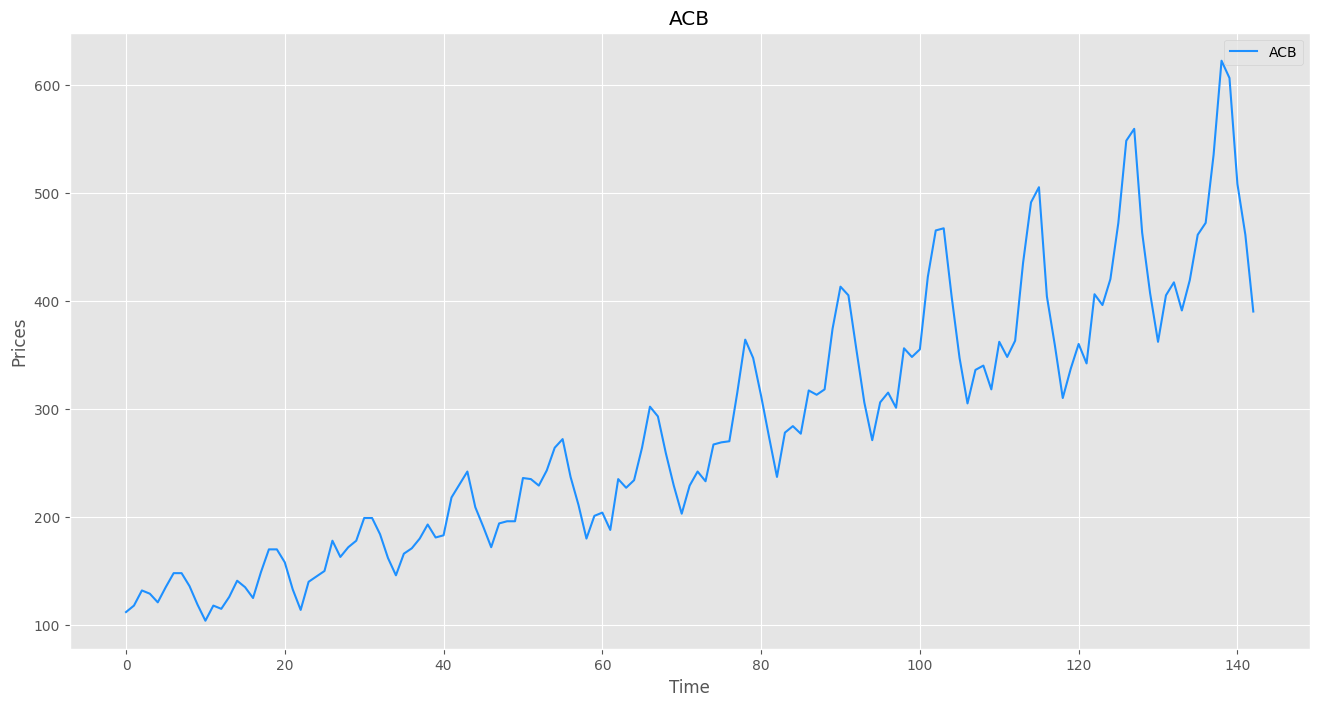

In [54]:
plt.figure(figsize=(16, 8))
plt.plot(df['ACB'], label = 'ACB', color = 'DodgerBlue')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('ACB')
plt.legend()
plt.show()

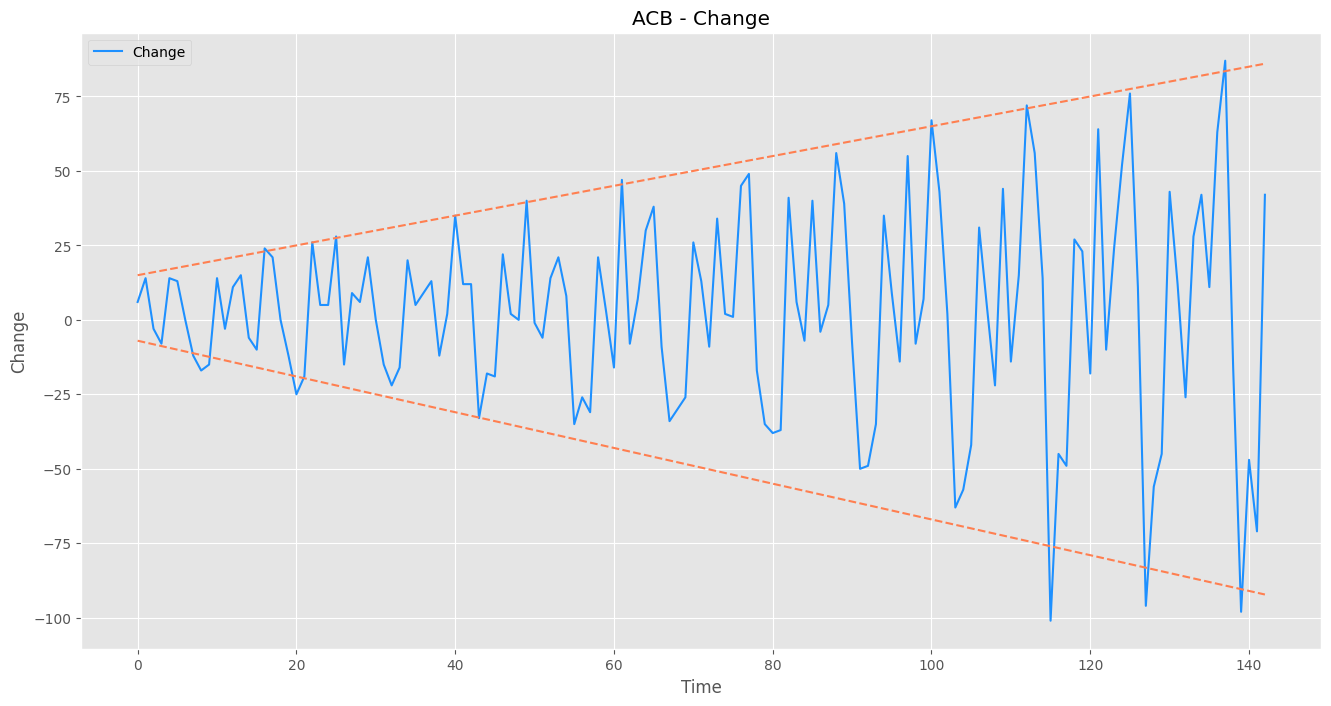

In [55]:
plt.figure(figsize=(16, 8))
plt.plot(df['Change'], label = 'Change', color = 'DodgerBlue')
plt.plot(df['Upper_Bound'], linestyle='--', color = 'Coral')
plt.plot(df['Lower_Bound'], linestyle='--', color = 'Coral')
plt.xlabel('Time')
plt.ylabel('Change')
plt.title('ACB - Change')
plt.legend()
plt.show()

Centroids:
[-0.754, 0.06, 0.763]
Devide Lines:
[-0.347, 0.412]


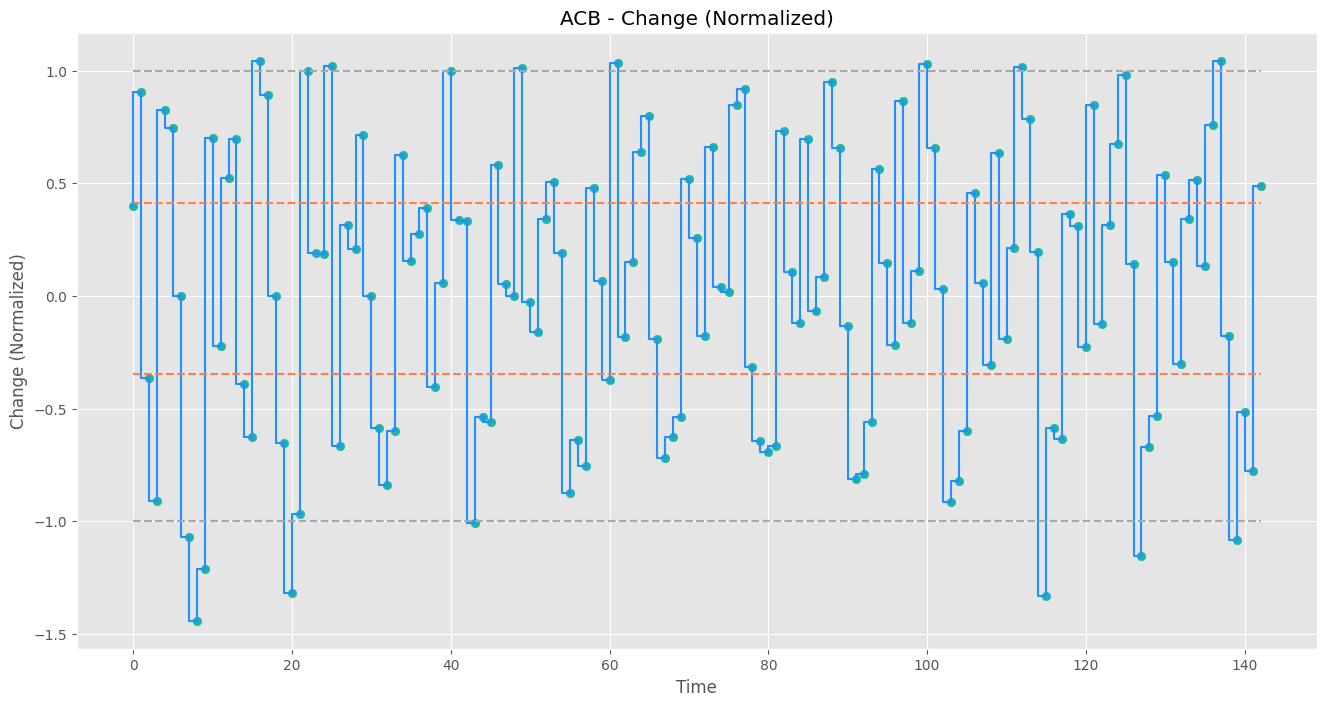

In [56]:
print('Centroids:')
print([round(c,3) for c in centroids])
print('Devide Lines:')
print([round(l,3) for l in devide_lines])

plt.figure(figsize=(16, 8))
plt.step(range(len(df)), df['Change_Normalized'], label = 'Change (Normalized)', color = 'DodgerBlue')
plt.scatter(range(len(df)), df['Change_Normalized'], color='LightSeaGreen')
plt.plot([ 1.0 for _ in range(len(df))], linestyle='--', color = 'DarkGray')
for line in devide_lines:
    plt.plot([line for _ in range(len(df))], linestyle='--', color = 'Coral')
plt.plot([-1.0 for _ in range(len(df))], linestyle='--', color = 'DarkGray')
plt.xlabel('Time')
plt.ylabel('Change (Normalized)')
plt.title('ACB - Change (Normalized)')
plt.show()

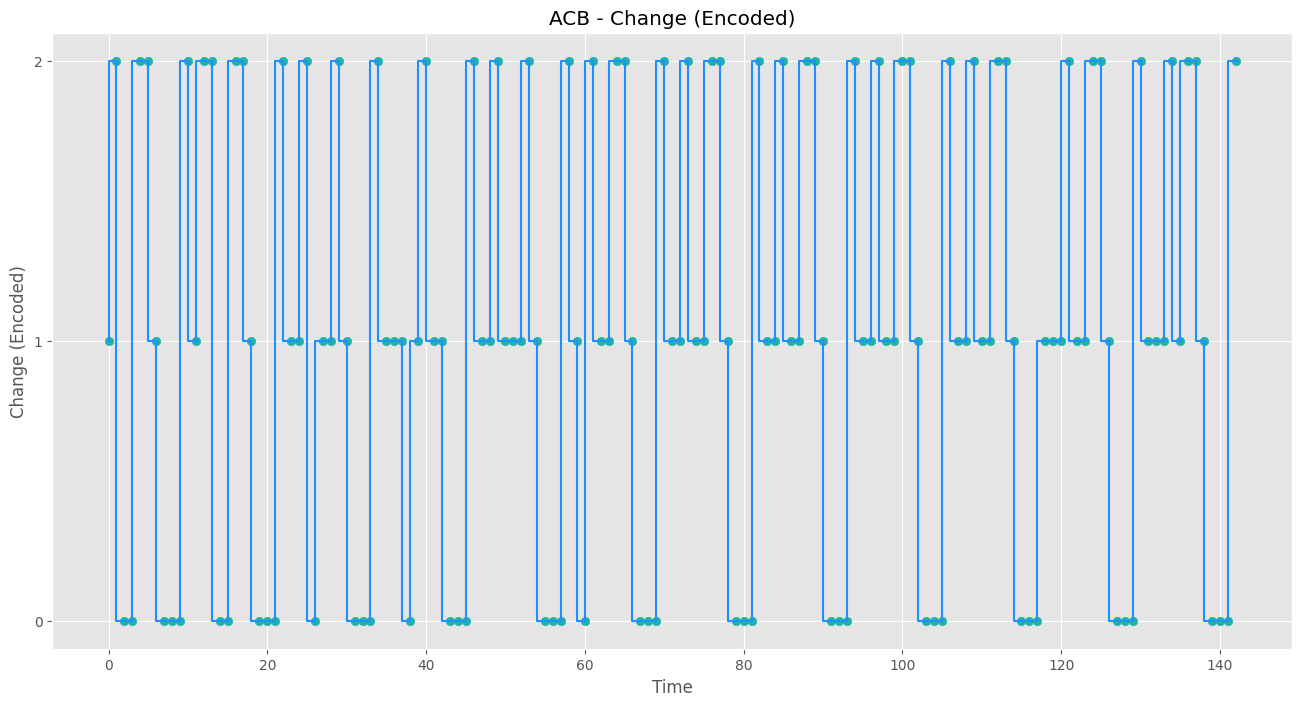

In [57]:
plt.figure(figsize=(16, 8))
plt.step(range(len(df)), df['Change_Encoded'], label = 'Change (Encoded)', color = 'DodgerBlue')
plt.scatter(range(len(df)), df['Change_Encoded'], color='LightSeaGreen')
plt.yticks(range(len(devide_lines)+1))
plt.xlabel('Time')
plt.ylabel('Change (Encoded)')
plt.title('ACB - Change (Encoded)')
plt.show()

### Chi tiết về hàm `loop_samples_in_minibatch_sequential`

#### Các tham số đầu vào
- `minibatch_set`: Danh sách các minibatch được chia ra từ tập dữ liệu.
- `U, V, W, B, b_out`: Các tham số của mạng LSTM.
- `d_U, d_V, d_W, d_B, d_f, h_s, h_s_s`: Các ma trận đạo hàm để tính toán gradient.
- `train_losses, valid_losses`: Mảng để lưu trữ các giá trị loss trên tập huấn luyện và tập validation.
- `outputs`: Mảng để lưu trữ các kết quả đầu ra của mạng LSTM.
- `round_decimal`: Số chữ số thập phân được làm tròn.

#### Các bước thực hiện

1. **Duyệt qua các minibatch trong tập dữ liệu validation và training**:
   - Sử dụng vòng lặp `for idx in range(len(minibatch_set))` để duyệt qua từng minibatch.
   - Trong mỗi minibatch, lấy ra `inputs` (dữ liệu đầu vào) và `targets` (dữ liệu đích).

2. **Forward Pass**:
   - Duyệt qua từng `idf` trong `inputs`.
   - Tính toán `h_s` (hidden state) và `outputs` (các output của mạng LSTM) bằng cách sử dụng các ma trận `U, V, W, B, b_out`.
   - Các giá trị `h_s`, `outputs` được lưu vào các biến tương ứng (`h_s`, `outputs`).

3. **Backward Pass**:
   - Duyệt qua từng `idb` theo chiều ngược lại của `inputs` (backward pass).
   - Tính toán gradient (`d_U, d_V, d_W, d_B, d_f`) để cập nhật các tham số của mạng LSTM.
   - Tính toán loss bằng cách so sánh `outputs` với `targets`.

4. **Gradient Clip**:
   - Tính toán `clip_coef` dựa trên các gradient để chuẩn hóa gradient.
   - Cập nhật các gradient nếu `clip_coef` nhỏ hơn 1.

5. **Lưu trữ thông tin**:
   - Lưu trữ giá trị loss của minibatch vào `train_losses` và `valid_losses`.

### Điểm lưu ý

- Mỗi minibatch được duyệt qua một cách tuần tự để tính toán forward và backward pass.
- Các gradient được tính toán và cập nhật dựa trên các tham số của mạng LSTM.
- Quá trình lan truyền ngược (`backward pass`) được sử dụng để tính toán gradient và cập nhật các tham số của mạng.
- Các hàm toán học như `tanh`, `softmax`, `log` được sử dụng để tính toán các phần tử trong quá trình lan truyền ngược và tính toán loss.


In [58]:
def loop_samples_in_minibatch_sequential(minibatch_set, U, V, W, B, b_out, d_U, d_V, d_W, d_B, d_f, h_s, h_s_s, train_losses, valid_losses, outputs, round_decimal):

    # For each sentence in validation set
    for idx in range(len(minibatch_set)):

        inputs = minibatch_set[idx][0]
        targets = minibatch_set[idx][1]

        # ------------------------------ Forward Pass ------------------------------
        for idf in range(len(inputs)):
            
            # h_s
            for r in range(hidden_size):
                d_f[idx][r][0] = 0.0
                for u in range(hidden_size):
                    d_f[idx][r][0] = round(d_f[idx][r][0] + (V[r][u] * h_s[idx][u][0]), round_decimal)
            for r in range(hidden_size):
                h_s_dot_1 = 0.0
                for u in range(vocab_size):
                    h_s_dot_1 = round(h_s_dot_1 + (U[r][u] * inputs[idf][u][0]), round_decimal)
                h_s[idx][r][0] = round(math.tanh(h_s_dot_1 + d_f[idx][r][0] + B[r][0]), round_decimal)

            # h_s_s
            for r in range(hidden_size):
                h_s_s[idx][idf][r][0] = h_s[idx][r][0]

            # outputs
            sum_softmax = 0.0
            for r in range(vocab_size):
                softmax = 0.0
                for u in range(W.shape[1]):
                    softmax = round(softmax + (W[r][u] * h_s[idx][u][0] + b_out[r][0]), round_decimal)
                sum_softmax = round(sum_softmax + math.exp(softmax + 1e-12), round_decimal)
                outputs[idx][idf][r][0] = round(math.exp(softmax + 1e-12), round_decimal)
            for r in range(vocab_size):
                outputs[idx][idf][r][0] = round(outputs[idx][idf][r][0] / sum_softmax, round_decimal)

        # ------------------------------ Backward Pass ------------------------------
        loss = 0
        for idb_r in range(hidden_size):
            h_s[idx][idb_r][0] = 0.0
        for idb_reversed in range(len(inputs)):
            idb = len(inputs) - idb_reversed - 1

            # loss
            loss_mean = 0.0
            for r in range(vocab_size):
                loss_mean = round(loss_mean + (math.log(outputs[idx][idb][r][0] + 1e-12) * targets[idb][r][0]), round_decimal)
            loss_mean = round(loss_mean / vocab_size, round_decimal)
            loss = round(loss - loss_mean, round_decimal)

            # outputs
            argmax_targets = 0
            for r in range(1, vocab_size):
                if targets[idb][r][0] > targets[idb][argmax_targets][0]:
                    argmax_targets = r
            outputs[idx][idb][argmax_targets][0] = outputs[idx][idb][argmax_targets][0] - 1

            # d_f
            for r in range(hidden_size):
                d_f_dot = h_s[idx][r][0]
                for u in range(vocab_size):
                    d_f_dot = round(d_f_dot + (W[u][r] * outputs[idx][idb][u][0]), round_decimal)
                d_f[idx][r][0] = round((1-math.pow(((math.exp(h_s_s[idx][idb][r][0] + 1e-12)-math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))/(math.exp(h_s_s[idx][idb][r][0] + 1e-12)+math.exp(-(h_s_s[idx][idb][r][0] + 1e-12)))), 2)) * d_f_dot, round_decimal)
                
            # h_s
            for r in range(hidden_size):
                h_s[idx][r][0] = 0.0
                for u in range(V.shape[0]):
                    h_s[idx][r][0] = round(h_s[idx][r][0] + (V[u][r] * d_f[idx][u][0]), round_decimal)

            # d_U
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_U_dot = round(d_U_dot + (d_f[idx][r][u] * inputs[idb][c][u]), round_decimal)
                    d_U[idx][r][c] = round(d_U[idx][r][c] + d_U_dot, round_decimal)

            # h_s_s
            for r in range(hidden_size):
                h_s_s[idx][-1][r][0] = h_s_s[idx][len(inputs)-1][r][0]

            # d_V
            for r in range(hidden_size):
                for c in range(hidden_size):
                    d_V_dot = 0.0
                    for u in range(d_f[idx].shape[1]):
                        d_V_dot = round(d_V_dot + (d_f[idx][r][u] * h_s_s[idx][idb-1][c][u]), round_decimal)
                    d_V[idx][r][c] = round(d_V[idx][r][c] + d_V_dot, round_decimal)

            # d_W
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W_dot = 0.0
                    for u in range(outputs[idx][idb].shape[1]):
                        d_W_dot = round(d_W_dot + (outputs[idx][idb][r][u] * h_s_s[idx][idb][c][u]), round_decimal)
                    d_W[idx][r][c] = round(d_W[idx][r][c] + d_W_dot, round_decimal)

            # d_B
            for r in range(hidden_size):
                d_B[idx][r][0] = round(d_B[idx][r][0] + d_f[idx][r][0], round_decimal)

        # ------------------------------ Gradient Clip ------------------------------
        # clip_coef
        clip_coef = 0.0
        for r in range(hidden_size):
            for c in range(vocab_size):
                clip_coef = round(clip_coef + d_U[idx][r][c] * d_U[idx][r][c], round_decimal)
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_V[idx][r][c] * d_V[idx][r][c], round_decimal)
            clip_coef = round(clip_coef + d_B[idx][r][0] * d_B[idx][r][0], round_decimal)
        for r in range(vocab_size):
            for c in range(hidden_size):
                clip_coef = round(clip_coef + d_W[idx][r][c] * d_W[idx][r][c], round_decimal)
        clip_coef = round(0.25 / (math.sqrt(clip_coef) + 1e-6), round_decimal)

        if clip_coef < 1.0:
            for r in range(hidden_size):
                for c in range(vocab_size):
                    d_U[idx][r][c] = round(d_U[idx][r][c] * clip_coef, round_decimal)
                for c in range(hidden_size):
                    d_V[idx][r][c] = round(d_V[idx][r][c] * clip_coef, round_decimal)
                d_B[idx][r][0] = round(d_B[idx][r][0] * clip_coef, round_decimal)
            for r in range(vocab_size):
                for c in range(hidden_size):
                    d_W[idx][r][c] = round(d_W[idx][r][c] * clip_coef, round_decimal)

        # ------------------------------ Save information ------------------------------
        valid_losses[idx] = round(loss, round_decimal)
        train_losses[idx] = round(loss, round_decimal)

Hàm `loop_minibatches` được thiết kế để duyệt qua các minibatch trong tập dữ liệu huấn luyện và thực hiện quá trình huấn luyện mạng neural. Đây là một hàm quan trọng trong quá trình huấn luyện mô hình mạng LSTM.

### Các tham số đầu vào của hàm:

- `implementation`: Phương pháp triển khai cho việc duyệt qua các mẫu trong minibatch. Trong trường hợp này, phương pháp được hỗ trợ là `sequential`.
  
- `minibatch_size`: Kích thước của mỗi minibatch.

- `train_valid_set`: Tập dữ liệu huấn luyện và validation được chia thành minibatch.

- `params`: Các tham số của mạng neural, bao gồm `U, V, W, B, b_out`.

- `all_valid_losses, all_train_losses`: Mảng để lưu trữ giá trị loss trên tập huấn luyện và tập validation.

- `all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B`: Mảng để lưu trữ các gradient của các tham số mạng neural.

- `epoch_idx`: Chỉ số của epoch hiện tại.

- `round_decimal`: Số chữ số thập phân được làm tròn.

- `optimize_method`: Phương pháp tối ưu hóa, trong trường hợp này là `minibatch`.

- `learning_rate`: Tốc độ học (learning rate) được sử dụng trong quá trình cập nhật tham số.

### Các bước thực hiện:

1. **Duyệt qua các minibatch**:
   - Sử dụng vòng lặp `for i in range(num_minibatchs)` để duyệt qua từng minibatch trong tập dữ liệu.
   - Tại mỗi minibatch, lấy ra `minibatch_set` (một phần của `train_valid_set`) để thực hiện quá trình huấn luyện.

2. **Gọi hàm thực hiện huấn luyện cho từng minibatch**:
   - Dựa vào `implementation` (phương pháp triển khai) để gọi hàm thích hợp, trong trường hợp này là `loop_samples_in_minibatch_sequential`.
   - Truyền các tham số cần thiết như `minibatch_set`, `params`, `batch_grads_d_U`, `batch_grads_d_V`, `batch_grads_d_W`, `batch_grads_d_B`, `d_f`, `hidden_states_MEM`, `h_s_MEM`, `batch_train_losses`, `batch_valid_losses`, `outputs_MEM`, `round_decimal` cho hàm thực hiện huấn luyện.

3. **Cập nhật các giá trị gradient và loss**:
   - Sau khi hoàn thành quá trình huấn luyện cho mỗi minibatch, cập nhật các giá trị `all_grads_d_U`, `all_grads_d_V`, `all_grads_d_W`, `all_grads_d_B`, `all_train_losses`, `all_valid_losses` tương ứng với các vị trí của minibatch trong tập dữ liệu huấn luyện.

4. **Cập nhật tham số mạng neural** (nếu áp dụng tối ưu hóa theo minibatch):
   - Tính toán gradient trung bình từ `batch_grads_d_U`, `batch_grads_d_V`, `batch_grads_d_W`, `batch_grads_d_B`.
   - Gọi hàm `update_parameters` để cập nhật các tham số của mạng neural (`params`) dựa trên gradient trung bình và `learning_rate`.

### Điểm lưu ý:

- Quá trình huấn luyện được thực hiện dựa trên minibatch để tăng tốc độ và giảm lượng bộ nhớ cần thiết.
- Các gradient được tính toán và lưu trữ tại mỗi minibatch, và sau đó sử dụng để cập nhật các tham số của mạng neural.
- Giá trị loss trên tập huấn luyện và tập validation cũng được lưu trữ để theo dõi hiệu suất của mạng neural qua từng epoch.

In [59]:
def loop_minibatches(implementation, minibatch_size, train_valid_set, params, all_valid_losses, all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, epoch_idx, round_decimal, optimize_method, learning_rate):

    U, V, W, B, b_out = params
    # Devide the train_or_val_set to mini-batch
    num_minibatchs = math.floor(len(train_valid_set)/minibatch_size) # This will ignore the last mini-batch that has smaller size
    # LOOP THROUGH MINI-BATCHES
    for i in range(num_minibatchs):

        batch_start = i * minibatch_size
        batch_end = min(batch_start + minibatch_size, len(train_valid_set))
        minibatch_set = train_valid_set[batch_start : batch_end]

        batch_train_losses = np.zeros(minibatch_size)
        batch_valid_losses = np.zeros(minibatch_size)
        batch_grads_d_U = np.zeros((minibatch_size, hidden_size, vocab_size))
        batch_grads_d_V = np.zeros((minibatch_size, hidden_size, hidden_size))
        batch_grads_d_W = np.zeros((minibatch_size, vocab_size, hidden_size))
        batch_grads_d_B = np.zeros((minibatch_size, hidden_size, 1))
        d_f = np.zeros((minibatch_size, hidden_size, 1))
        hidden_states_MEM = np.zeros((minibatch_size, hidden_size, 1))
        outputs_MEM = np.zeros((minibatch_size, 999, vocab_size, 1))
        h_s_MEM = np.zeros((minibatch_size, 999, hidden_size, 1))

        if optimize_method == 'minibatch':
            # Re-initialize all_grads
            all_grads = [0] * len(train_valid_set)
            all_grads_d_U = [0] * len(train_valid_set)
            all_grads_d_V = [0] * len(train_valid_set)
            all_grads_d_W = [0] * len(train_valid_set)
            all_grads_d_B = [0] * len(train_valid_set)

        # LOOP THROUGH SAMPLES IN A MINI-BATCH
        if implementation == 'sequential':
            loop_samples_in_minibatch_sequential(minibatch_set, U, V, W, B, b_out, batch_grads_d_U, batch_grads_d_V, batch_grads_d_W, batch_grads_d_B, d_f, hidden_states_MEM, h_s_MEM, batch_train_losses, batch_valid_losses, outputs_MEM, round_decimal)
        else:
            raise Exception("Please specify the implementation method!") 

        # Copy `minibatch_` back to `all_`
        all_grads_d_U[batch_start : batch_end] = batch_grads_d_U
        all_grads_d_V[batch_start : batch_end] = batch_grads_d_V
        all_grads_d_W[batch_start : batch_end] = batch_grads_d_W
        all_grads_d_B[batch_start : batch_end] = batch_grads_d_B
        all_train_losses[batch_start : batch_end] = batch_train_losses
        all_valid_losses[batch_start : batch_end] = batch_valid_losses

        if optimize_method == 'minibatch':
        # Calculate mean of grads + Update params
            all_grads = [np.mean(batch_grads_d_U, axis=0), np.mean(batch_grads_d_V, axis= 0), np.mean(batch_grads_d_W, axis= 0), np.mean(batch_grads_d_B, axis=0)]
            params = update_parameters(params, all_grads, lr = learning_rate)

Hàm `train_LSTM` được sử dụng để huấn luyện mạng LSTM dựa trên các tham số và tập dữ liệu huấn luyện và validation đã cho. Bên dưới là mô tả các bước và các tham số trong hàm này:

### Các tham số đầu vào của hàm:

- `implementation`: Phương pháp triển khai cho việc duyệt qua các mẫu trong minibatch. Trong trường hợp này, phương pháp được hỗ trợ là `sequential`.

- `num_epochs`: Số lượng epoch (vòng lặp huấn luyện).

- `minibatch_size`: Kích thước của mỗi minibatch.

- `round_decimal`: Số chữ số thập phân được làm tròn.

- `learning_rate`: Tốc độ học (learning rate) được sử dụng trong quá trình cập nhật tham số.

- `epochs_per_print`: Số lượng epoch để in ra thông tin về loss.

- `optimize_method`: Phương pháp tối ưu hóa, trong trường hợp này là `fullbatch`.

- `hidden_size`, `vocab_size`: Kích thước của không gian ẩn và không gian từ vựng.

### Các bước thực hiện:

1. **Khởi tạo mạng neural LSTM**:
   - Gọi hàm `init_lstm` để khởi tạo các tham số của mạng LSTM như `U, V, W, B, b_out`.

2. **Huấn luyện qua các epoch**:
   - Sử dụng vòng lặp `for i in range(num_epochs+1)` để duyệt qua từng epoch.
  
3. **Duyệt qua tập validation và tập huấn luyện**:
   - Gọi hàm `loop_minibatches` để duyệt qua các minibatch trong tập validation và tập huấn luyện.
   - Trong mỗi minibatch, tính toán gradient và loss sử dụng `loop_minibatches`.

4. **Cập nhật tham số mạng neural**:
   - Nếu sử dụng `fullbatch` là phương pháp tối ưu hóa, tính toán gradient trung bình từ các minibatch và gọi hàm `update_parameters` để cập nhật các tham số của mạng.

5. **Tính toán và lưu trữ loss**:
   - Tính toán tổng loss trên tập huấn luyện và tập validation.
   - Lưu trữ giá trị loss vào `training_loss` và `validation_loss` để theo dõi sự tiến bộ của mô hình.

6. **In thông tin về loss**:
   - In ra thông tin về loss sau mỗi số epoch nhất định (`epochs_per_print`).

### Lưu ý:

- Trong quá trình huấn luyện, các gradient được tính toán trên từng minibatch và sau đó sử dụng để cập nhật các tham số của mạng neural.
- Các giá trị loss được tính toán và lưu trữ để đánh giá hiệu suất của mô hình qua từng epoch.
- Mô hình được huấn luyện qua các vòng lặp epoch để tối ưu hóa hàm mất mát và cải thiện hiệu suất dự đoán của mạng LSTM.

In [60]:
def train_LSTM(implementation, num_epochs = 100, minibatch_size = 2, round_decimal = 10, learning_rate = 10e-1, epochs_per_print = 1, optimize_method = 'fullbatch', hidden_size = hidden_size, vocab_size = vocab_size):

    print(f"Implementation: {implementation}")

    # Initialize a new network
    params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size)

    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))

    # Track loss
    training_loss, validation_loss = [], []

    # For each epoch
    for i in range(num_epochs+1):
        
        # Track loss
        epoch_training_loss = 0
        epoch_validation_loss = 0
        all_grads = [0] * len(training_set)
        all_grads_d_U = [0] * len(training_set)
        all_grads_d_V = [0] * len(training_set)
        all_grads_d_W = [0] * len(training_set)
        all_grads_d_B = [0] * len(training_set)

        all_train_losses = np.zeros(len(training_set))
        all_valid_losses = np.zeros(len(validation_set))
        all_valid_losses_dummy = np.zeros(len(training_set))

        # Loop through validation set
        loop_minibatches(implementation, minibatch_size, validation_set_one_hot, params, all_valid_losses,       all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, i, round_decimal, optimize_method, learning_rate)
        # Loop through training set
        loop_minibatches(implementation, minibatch_size, training_set_one_hot,   params, all_valid_losses_dummy, all_train_losses, all_grads_d_U, all_grads_d_V, all_grads_d_W, all_grads_d_B, i, round_decimal, optimize_method, learning_rate)
        
        if optimize_method == 'fullbatch':
            # Calculate mean of grads + Update params
            for tmpi in range(len(all_grads)):
                all_grads[tmpi] = [all_grads_d_U[tmpi], all_grads_d_V[tmpi], all_grads_d_W[tmpi], all_grads_d_B[tmpi]]
            avg_grads = np.mean(all_grads, axis = 0)
            params = update_parameters(params, avg_grads, lr = learning_rate)

        # Calculate sum of losses
        epoch_training_loss = np.sum(all_train_losses)
        epoch_validation_loss = np.sum(all_valid_losses)

        # Save loss for plot
        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

        # Print loss
        if i % epochs_per_print == 0:
            print(f'Epoch {i}:\tTrain Loss = {round(training_loss[-1], 2)}\tValid Loss = {round(validation_loss[-1], 2)} \t ({training_loss[-1]} \t {validation_loss[-1]})')
            if round(training_loss[-1], round_decimal) == round(2.8779136835389827, round_decimal) and round(validation_loss[-1], round_decimal) == round(3.0435489866142853, round_decimal):
                print(f'👍👍👍👍👍👍👍👍👍👍\n' * 1)

    return params, training_loss, validation_loss

In [61]:
# Sequential
params, training_loss, validation_loss = train_LSTM(
    implementation = 'sequential', 
    num_epochs = 5, 
    minibatch_size = len(validation_set), 
    round_decimal = 10, 
    learning_rate = 0.1, 
    epochs_per_print = 1, 
    optimize_method = 'minibatch'
)

Implementation: sequential


Epoch 0:	Train Loss = 3.14	Valid Loss = 4.25 	 (3.1414521022406783 	 4.245239706742858)
Epoch 1:	Train Loss = 2.15	Valid Loss = 2.65 	 (2.1502498591355934 	 2.6530450142285713)
Epoch 2:	Train Loss = 1.7	Valid Loss = 2.08 	 (1.7002917540762712 	 2.0789591769142857)
Epoch 3:	Train Loss = 1.48	Valid Loss = 1.82 	 (1.4839553000169492 	 1.8234639934857142)
Epoch 4:	Train Loss = 1.38	Valid Loss = 1.7 	 (1.3786384088728814 	 1.7032757185714285)
Epoch 5:	Train Loss = 1.33	Valid Loss = 1.65 	 (1.3275782243847458 	 1.6485933981999998)


In [62]:
df = predict_ACB(df, params, raw_data, centroids, devide_lines)
actual_and_predicted = create_actual_and_predicted_df(df)

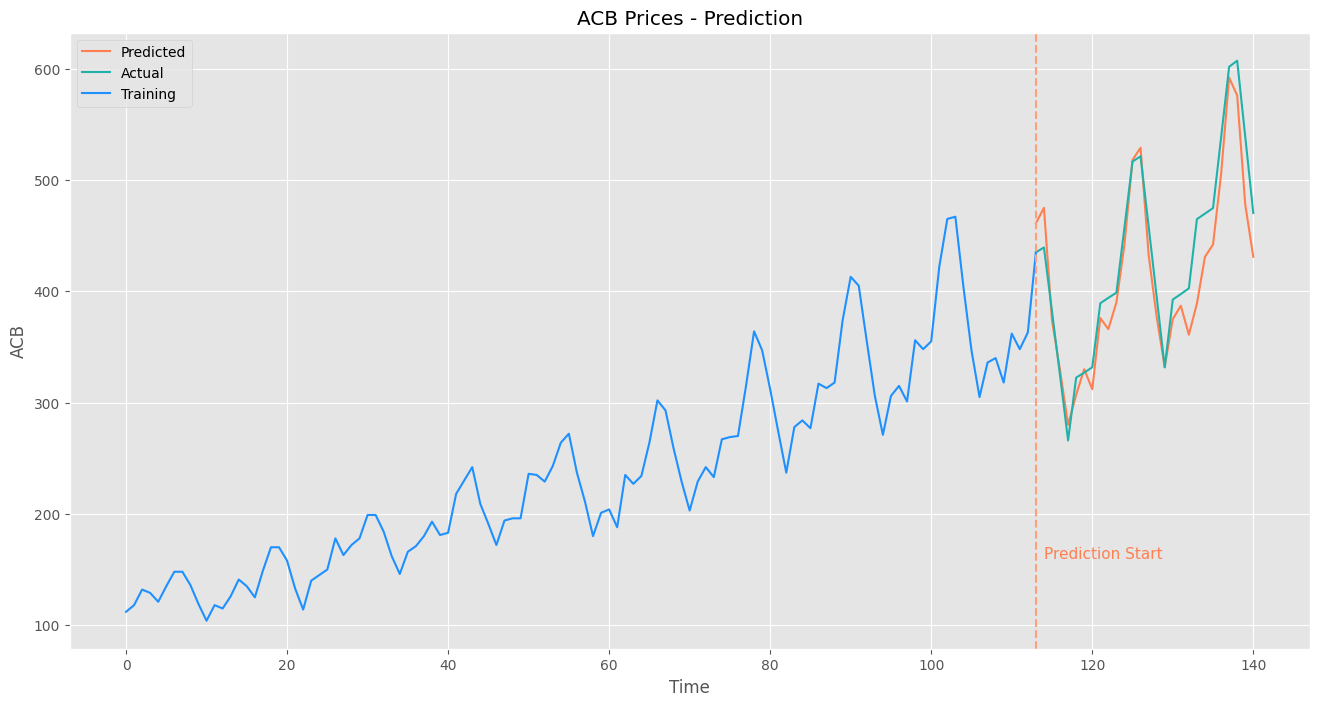

In [63]:
plt.figure(figsize=(16, 8))
plt.plot(actual_and_predicted['Actual'], label='Predicted', color='Coral')
plt.plot(actual_and_predicted['Predicted'], label='Actual', color = 'LightSeaGreen')
plt.plot(df['ACB'][:int(prediction_start * len(df))], label='Training', color = 'DodgerBlue')
plt.xlabel('Time')
plt.ylabel('ACB')
plt.title('ACB Prices - Prediction')
plt.axvline(x = int(prediction_start * len(df)) - 1, linestyle='--', color='LightSalmon')
plt.text(114, 160, 'Prediction Start', fontsize=11, color='Coral')
plt.legend()
plt.show()